# ASDC Data Processing Tool

The following notebook downloads tropospheric nitrogen dioxide column data from NASA's Troposoperic Emissions: Monitoring of Pollution (TEMPO) instrument.

For validation, the notebook also downloads tropospheric nitrogen dioxide column data from the Pandora Project, as well as meteorological variables from NASA's Power Project, and ground sensor variables captured using Environmental Protection Agencies (EPA)'s AirNow sensors via pyrsig.

Additional information on all downloaded data can be found at the links below.

- [TEMPO](https://www.earthdata.nasa.gov/data/instruments/tempo)
- [PANDORA](https://pandora.gsfc.nasa.gov/)
- [POWER](https://power.larc.nasa.gov/data-access-viewer/)
- [AIRNOW](https://gaftp.epa.gov/Air/aqmg/bhenders/presentations/pyrsig_2023-07-20.pdf)

For further validation assessment, user can perform Random Forest or Linear Regression on chosen variables over given time frame.

## User Requirements
- User must have a NASA earthaccess account
- Notebook assumes execution in local directory
- 



## Notes on TEMPO NO2 validation
This notebook illustrates comparison of nitrogen dioxide tropospheric column retrievals by TEMPO and Pandora ground stations.

It allows a user to choose Pandora station of interest. Since TEMPO spatial coverage is regional and limited to North America, it is user's responsibilty to select the station within TEMPO's field of regard (FOR). If the selected station is outside FOR, no TEMPO time series will be generated.

The user is allowed to choose the time period of interest by providing start and end dates in the form YYYYMMDD. Please be aware, that if the selecte period of interest is outside of available time span of one of the sensors, corresponding time series will not be generated.

Data files for both sensors are downloaded on-the-fly. TEMPO data are downloaded with earthaccess library that needs to be installed first.

TEMPO data files are read by means of netCDF library that needs to be installed first.

Pandora data files are ASCII files with header and space separated columns. Custome made function is included to read nitrogen dioxide total column along with its total uncertainty.

This code takes into account quality flags (QFs) from both TEMPO and Pandora. This is implemented as follow. On the TEMPO side, data set "/product/main_data_quality_flag" is read, all pixels with non-zero QFs are discarded. However, negative values of tropospheric NO2 column are NOT discarded and used for averaging/interpolationg to the point of interest. For the purpose of physical sanity, another way is also implemented, i.e., negative retrievals are not used in averaging. Therefore, TWO values are returned, trop_NO2_col, and trop_NO2_col_noneg. On Pandora side negative columns also occur despite high quality flags, though they are rare. So, two Pandora time series are considered - with and without negative columns.

The resulting time series are plotted with and without uncertainty of both measurement in the end of the notebook.

This notebook is tested on TEMPO_NO2_L2_V03 and Pandora L2_rnvh3p1-8 files.

In [46]:
# !pip3 install netCDF4

In [2]:
# !pip3 install earthaccess

In [1]:
!python -m pip install -qq xarray pyproj pyrsig pycno

Importing necessary libraries

In [2]:
import earthaccess # needed to discover and download TEMPO data
import netCDF4 as nc # needed to read TEMPO data
import os
import sys
import re
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")
import platform
from subprocess import Popen
import shutil
import seaborn as sns

from shapely.geometry import Point, Polygon # needed to search a point within a polygon
from scipy.interpolate import griddata # needed to interpolate TEMPO data to the point of interest
from scipy import stats # needed for linear regression analysis

import requests # needed to search for and download Pandora data
import codecs # needed to read Pandora data
import numpy as np

import matplotlib.pyplot as plt # needed to plot the resulting time series
from urllib.request import urlopen, Request # needed to search for and download Pandora data
from pathlib import Path # needed to check whether a needed data file is already downloaded
from datetime import datetime, timedelta # needed to work with time in plotting time series
import math

import pyproj
import xarray as xr
import pyrsig
import pandas as pd
# import pycno
import getpass
import matplotlib.pyplot as plt
import folium

from typing import List, Union, Optional
from pathlib import Path
from datetime import date, datetime
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))
import time
import os
import pandas as pd
from IPython.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

pd.set_option('display.max_columns', None)


# Functions

## Pandora Functions

In [3]:
# functions to work with pandora
## function creating the list of available Pandora Sites
# function read_pandora_web returns the list of available Pandora sites
def read_pandora_web():
  url = 'https://data.pandonia-global-network.org/'
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  html_len = len(html)

  pos1 = 0

  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  refs = []
  for line in ref_lines:
    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and line[pos1+1] == '.':
      refs.append(line[pos1+3 : pos2-1])

  return refs
##functions allowing user to choose a Pandora site of interest
# function check_site checks whether user entered site is in the list of available Pandora sites
def check_site(site_name, refs):
  site_list = []
  for line in refs:
    if site_name in line:
      site_list.append(line)

  return site_list


# function take_pandora_sites takes user input and checks whether the site is in the list of available Pandora sites
def take_pandora_sites(refs):
  print('please select a Pandora site name from the list')
  for ref in refs:
    print(ref)

  answer = 'y'
  while answer == 'y':
    site_name = input('Enter a name of a Pandora site: ')
    print(site_name)
    site_list = check_site(site_name, refs)
    site_num = len(site_list)
    if site_num == 0:
      print('site ', site_name, 'was not found')
      continue

    if site_num > 1:
      print('there are ', site_num, ' site names, select one from')
      for site in site_list: print(site)

      site_name = input('Enter a name of a Pandora site: ')
      if site_list.count(site_name) != 1:
        print('Entered name is not the exact match of one of the following sites')
        for site in site_list: print(site)
        print('program terminated')
        sys.exit()

      for site in site_list:
        if site == site_name:
          pandora_site = site_name
          print('site ', site_name, 'was found and added to the list of sites ')
          break

    if site_num == 1:
      pandora_site = site_list[0]
      print('site ', site_list[0], 'was found and added to the list of sites ')

    answer = 'n'

  return pandora_site
##function creating the list of links to tropospheric NO2 data files at the selected Pandora sites and downloading the data files
# Pandora site may have several instruments. In this case each instrument has its own directory.
# However, the most recent version of the troposperic NO2 data, rnvh3p1-8, is available only in one of these directories.
# The function creates all possible links, but some of them may be non-existing. This is checked and cleared later.
def instrument_path(site):
# function instrument_path returns links to possible Pandora NO2 retrievals files
  url = 'https://data.pandonia-global-network.org/' + site + '/'
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  html_len = len(html)

  pos1 = 0
  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  links = []
  for line in ref_lines:

    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and\
       line[pos1+3 : pos1 + 10] == 'Pandora':
      link = url + line[pos1+3 : pos2] + 'L2/' + line[pos1+3 : pos2-1] + '_' + site + '_L2_rnvh3p1-8.txt'
      print(link)
      links.append(link)

  return links


# function downloading Pandora data file with given url
def download(url):
  response = requests.get(url)
  response_code = response.status_code

  file_name = url.split('/')[-1]

  if response_code == 200:
    content = response.content
    data_path = Path(file_name)
    data_path.write_bytes(content)

  return file_name, response_code
##unction reading Pandora NO2 data files rnvh3p1-8
# function converting Pandora timestamp into a set of  year, month, day, hour, minute, and second
# function read_timestamp converts Pandora timestamp of the format
# 'yyyymmddThhmmssZ' into a set of 6 numbers:
# integer year, month, day, hour, minute, and real second.
def read_timestamp(timestamp):

  yyyy = int(timestamp[0:4])
  mm = int(timestamp[4:6])
  dd = int(timestamp[6:8])
  hh = int(timestamp[9:11])
  mn = int(timestamp[11:13])
  ss = float(timestamp[13:17])

  return yyyy, mm, dd, hh, mn, ss


# function reading Pandora NO2 data file rnvh3p1-8
#
# Below is the second version of function read_Pandora_NO2_rnvs3p1_8. It is to be used for the future validation efforts.
# The difference with the original version is that instead of discriminating negative values of the total NO2 column,
# it uses quality flags. It was previously found that QF == 0 does not occure often enough,
# so we will have to use QF == 10 (not-assured high quality).
#
# function read_Pandora_NO2_rnvh3p1_8 reads Pandora total NO2 column data files ending with rnvh3p1-8.
# Arguments:
# fname - name file to be read, string;
# start_date - beginning of the time interval of interest,
#              integer of the form YYYYMMDD;
# end_date -   end of the time interval of interest,
#              integer of the form YYYYMMDD.
#
# if start_date is greater than end_date, the function returns a numpy array
# with shape (0, 8), otherwise it returns an 8-column numpy array
# with with columns being year, month, day, hour, minute, second of observation
# and retrieved total NO2 column along with its total uncertainty.
#
# NO2 column is in mol/m^2, so conversion to molecules/cm^2 is performed by
# multiplication by Avogadro constant, NA =  6.02214076E+23, and division by 1.E+4
def read_Pandora_NO2_rnvh3p1_8(fname, start_date, end_date):

  conversion_coeff = 6.02214076E+19 # Avogadro constant divided by 10000

  data = np.empty([0, 8])
  if start_date > end_date: return -999., -999., data

  with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:

    while True:
# Get next line from file
      line = f.readline()

      if line.find('Short location name:') >= 0:
        loc_name = line.split()[-1] # location name, to be used in the output file name
        print('location name ', loc_name)

      if line.find('Location latitude [deg]:') >= 0:
        lat = float(line.split()[-1]) # location latitude
        print('location latitude ', lat)

      if line.find('Location longitude [deg]:') >= 0:
        lon = float(line.split()[-1]) # location longitude
        print('location longitude ', lon)

      if line.find('--------') >= 0: break

    while True:
# Get next line from file
      line = f.readline()
      # print(line)
      if line.find('--------') >= 0: break

    while True:
# now reading line with data
      line = f.readline()
      
      if not line: break

      line_split = line.split()
     
      yyyy, mm, dd, hh, mn, ss = read_timestamp(line_split[0])
      date_stamp = yyyy*10000 + mm*100 + dd
      if date_stamp < start_date or date_stamp > end_date: continue

      QF = int(line_split[52]) # total column uncertainty

      if QF == 0 or QF == 10:
        column = float(line_split[61]) # Nitrogen dioxide tropospheric vertical column amount [moles per square meter]
        column_unc = float(line_split[62]) # Independent uncertainty of nitrogen dioxide tropospheric vertical column amount [moles per square meter]
        data = np.append(data, [[yyyy, mm, dd, hh, mn, ss\
                               , column*conversion_coeff\
                               , column_unc*conversion_coeff]], axis = 0)

  return lat, lon, loc_name, data


## TEMPO Functions

In [4]:
#funciton reading TEMPO NO2 data file
# function reading TEMPO NO2 data file for tropospheric column
def read_TEMPO_tropNO2_L2(fn):
  '''
  function read_TEMPO_tropNO2_L2 reads the following arrays from the
  TEMPO L2 NO2 product TEMPO_NO2_L2_V03:
    vertical_column_troposphere;
    vertical_column_troposphere_uncertainty;
  and returns respective fields along with coordinates of the pixels.

  If one requested variables cannot be read, all returned variables are zeroed
  '''
  var_name = 'vertical_column_troposphere'
  var_unc_name = 'vertical_column_troposphere_uncertainty'
  var_QF_name = 'main_data_quality_flag'

  try:
    ds = nc.Dataset(fn)

    prod = ds.groups['product'] # this opens group product, /product, as prod

    var = prod.variables[var_name] # this reads variable column_amount_o3 from prod (group product, /product)
    trop_NO2_column = np.array(var)
    fv_prod = var.getncattr('_FillValue')
    prod_unit = var.getncattr('units')

    var_unc = prod.variables[var_unc_name] # this reads variable column_amount_o3 from prod (group product, /product)
    trop_NO2_column_unc = np.array(var_unc)

    var_QF = prod.variables[var_QF_name] # this reads variable column_amount_o3 from prod (group product, /product)
    trop_NO2_column_QF = np.array(var_QF)
    fv_QF = var_QF.getncattr('_FillValue')

    geo = ds.groups['geolocation'] # this opens group geolocation, /geolocation, as geo

    lat = np.array(geo.variables['latitude']) # this reads variable latitude from geo (geolocation group, /geolocation) into a numpy array
    lon = np.array(geo.variables['longitude']) # this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array
    fv_geo = geo.variables['latitude'].getncattr('_FillValue')
    time = np.array(geo.variables['time'] )# this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array

    ds.close()

  except:
    print('variable '+var_name+' cannot be read in file '+fn)
    lat = 0.
    lon = 0.
    time = 0.
    fv_geo = 0.
    trop_NO2_column = 0.
    trop_NO2_column_unc = 0.
    trop_NO2_column_QF = 0.
    fv_prod = 0.
    fv_QF = -999
    prod_unit = ''
  return lat, lon, fv_geo, time, trop_NO2_column, trop_NO2_column_unc\
, trop_NO2_column_QF, fv_prod, fv_QF, prod_unit


## Processing Functions

In [32]:
def celsius_to_fahrenheit(celsius):
  return (celsius * 9/5) + 32

def convert_to_decimal(coord):
    """Convert coordinates from '38.9262N' format to decimal degrees."""
    match = re.match(r"(\d+\.\d+)([NSEW])", coord)
    if not match:
        raise ValueError(f"Invalid coordinate format: {coord}")
    
    value, direction = float(match.group(1)), match.group(2)
    
    if direction in ['S', 'W']:
        return -value  # South and West are negative
    return value  # North and East are positive

def txt_to_df(text_file):
    with open(text_file, 'r') as file:
        header1 = file.readline()
        header2 = file.readline()
        tempo = file.readlines()
    
        tempo_no2 = {
        'date': [], 'NO2': [], 'NO2_UNC': [], 'LAT_NE': [], 'LON_NE': [], 'NO2_NE': [], 'UNC_NE': [],
        'LAT_SE': [], 'LON_SE': [], 'NO2_SE': [], 'UNC_SE': [], 'LAT_SW': [], 'LON_SW': [], 'NO2_SW': [],
        'UNC_SW': [], 'LAT_NW': [], 'LON_NW': [], 'NO2_NW': [], 'UNC_NW': []
    }
    
        for line in tempo:
            split = line.split()
            date = datetime(int(split[0]), int(split[1]), int(split[2]), int(split[3]), int(split[4]))
            
            tempo_no2['date'].append(date)
            tempo_no2['NO2'].append(int(float(split[6])))
            tempo_no2['NO2_UNC'].append(int(float(split[7])))
            tempo_no2['LAT_NE'].append(convert_to_decimal(split[8]))  
            tempo_no2['LON_NE'].append(convert_to_decimal(split[9]))  
            tempo_no2['NO2_NE'].append(float(split[10]))  
            tempo_no2['UNC_NE'].append(float(split[11]))  
            tempo_no2['LAT_SE'].append(convert_to_decimal(split[12]))  
            tempo_no2['LON_SE'].append(convert_to_decimal(split[13])) 
            tempo_no2['NO2_SE'].append(int(float(split[14])))
            tempo_no2['UNC_SE'].append(int(float(split[15])) )            
            tempo_no2['LAT_SW'].append(convert_to_decimal(split[16]))  
            tempo_no2['LON_SW'].append(convert_to_decimal(split[17]))  
            tempo_no2['NO2_SW'].append(int(float(split[18])))
            tempo_no2['UNC_SW'].append(int(float(split[19])))
            tempo_no2['LAT_NW'].append(convert_to_decimal(split[20]))  
            tempo_no2['LON_NW'].append(convert_to_decimal(split[21]))  
            tempo_no2['NO2_NW'].append(int(float(split[22])))
            tempo_no2['UNC_NW'].append(int(float(split[23])))
            
    df = pd.DataFrame(tempo_no2)
    return df

def tempo_processing(file, year, save=False, filename = ''):
    df = txt_to_df(file)
    df['datetime'] = pd.to_datetime(df['date'])
    df["year"], df["month"], df["day"], df["hour"], df["minute"] = df["date"].dt.year,df["date"].dt.month, df["date"].dt.day, df["date"].dt.hour, df["date"].dt.minute
    
    # Group by month and day, then print unique hours for each day
    sun = {'month':[],'day':[], 'date_range_start':[], 'date_range_end':[]}
    for (month, day), group in df.groupby(["month", "day"]):
        unique_hours = sorted(group["hour"].unique())  # Sort for readability
        # print(f"Month {month}, Day {day}: Hours -> {unique_hours[0]} through {unique_hours[-1]}")
        sun['month'].append(month.item())
        sun['day'].append(day.item())
        sun['date_range_start'].append(unique_hours[0].item())
        sun['date_range_end'].append(unique_hours[-1].item())
    
    sun = pd.DataFrame(sun)
    all_rows = []
    for _, row in sun.iterrows():
        for hour in range(row["date_range_start"], row["date_range_end"] + 1):
            all_rows.append({
                "year": year,
                "month": row["month"],
                "day": row["day"],
                "hour": hour,
                "datetime": pd.Timestamp(f"{year}-{row['month']:02d}-{row['day']:02d} {hour:02d}:00:00")
            })
    
    df_complete = pd.DataFrame(all_rows)
    final_df = pd.merge(df, df_complete, on=["year", "month", "day", "hour"], how="outer")
    final_df = final_df.drop(columns = [ 'datetime_x', 'date'])
    
    final_df = final_df.rename(columns = {'datetime_y': 'datetime'})
    if save: final_df.to_csv(filename +'.csv',index=False)
    return final_df

def pandora_processing(file_path, year=2024, day_start = 0, day_end = 0, interpolate_missing = True, save = False, filename=''):
    columns = ["year", "month", "day", "hour", "minute", "second", "NO2", "unc"]
    df = pd.read_csv(file_path, sep = '\s+', names=columns)    
    df = df.groupby(["year", "month", "day", "hour"], as_index=False)["NO2"].mean()
    df = df.rename(columns = {'NO2': 'NO2_pan'})
    
    df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df["year"], df["month"], df["day"], df["hour"] = df["date"].dt.year,df["date"].dt.month, df["date"].dt.day, df["date"].dt.hour

    sun = {'year': [], 'month':[],'day':[], 'date_range_start':[], 'date_range_end':[]}
    for (year, month, day), group in df.groupby(["year", "month", "day"]):
        unique_hours = sorted(group["hour"].unique())  
        # print(f"Month {month}, Day {day}: Hours -> {unique_hours[0]} through {unique_hours[-1]}")
        sun['year'].append(year)
        sun['month'].append(month)
        sun['day'].append(day)
        sun['date_range_start'].append(unique_hours[0])
        sun['date_range_end'].append(unique_hours[-1])
    sun = pd.DataFrame(sun)
    
    min_date = df["date"].min().date()
    max_date = df["date"].max().date()
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    last_available_start = None
    last_available_end = None
    all_rows = []

    #Need to create full dataframes with missing values, some days are missing entirely and must be handled separately from when only a few hour measurements are missing
    for single_date in full_date_range:
        year, month, day = single_date.year, single_date.month, single_date.day
        sun_row = sun[(sun["year"] == year) & (sun["month"] == month) & (sun["day"] == day)]
        if not sun_row.empty:
            last_available_start = sun_row["date_range_start"].values[0]
            last_available_end = sun_row["date_range_end"].values[0]
        elif last_available_start is not None and last_available_end is not None:
            # If day is missing, insert it with the last available hours
            for hour in range(last_available_start, last_available_end + 1):
                all_rows.append({"year": year, "month": month, "day": day, "hour": hour})
    
    df_complete = pd.DataFrame(all_rows)
    final_df = pd.concat([df,df_complete], ignore_index=True).sort_values(["year", "month", "day", "hour"])
    final_df = final_df.drop_duplicates(subset=["year", "month", "day", "hour"], keep="first").reset_index()
    
    if day_start != 0 and day_end != 0:
        final_df = final_df[(final_df['day'] >= day_start) & (final_df['day'] <= day_end)]
    
    final_df['date'] = pd.to_datetime(final_df[['year', 'month', 'day', 'hour']])
    final_df = final_df.drop(columns = ['index'])

    #handle missing hourly data
    sun = {'month':[],'day':[], 'date_range_start':[], 'date_range_end':[]}
    for (month, day), group in final_df.groupby(["month", "day"]):
        unique_hours = sorted(group["hour"].unique())
    
        sun['month'].append(month.item())
        sun['day'].append(day.item())
        sun['date_range_start'].append(unique_hours[0].item())
        if day == 19: sun['date_range_end'].append(20)
        else: sun['date_range_end'].append(unique_hours[-1].item())
    
    sun = pd.DataFrame(sun)
    all_rows = []
    for _, row in sun.iterrows():
        for hour in range(row["date_range_start"], row["date_range_end"] + 1):
            all_rows.append({
                "year": year,
                "month": row["month"],
                "day": row["day"],
                "hour": hour,
                "date": pd.Timestamp(f"{year}-{row['month']:02d}-{row['day']:02d} {hour:02d}:00:00")
            })
    
    df_complete = pd.DataFrame(all_rows)
    final_df2 = pd.merge(final_df, df_complete, on=["year", "month", "day", "hour"], how="outer")
    final_df2['Timestamp'] = pd.to_datetime(final_df2[['year', 'month', 'day', 'hour']])
    final_df2 = final_df2.drop(columns = ['date_x', 'date_y'])
    
    if interpolate_missing:
        final_df2 = final_df2.interpolate('linear')
        
    if save: final_df2.to_csv(filename+'.csv', index=False)
    return final_df2

def airnow_processing(no2csv_path, pm25csv_path, year=2024, interpolate_missing=True, save=True, filename=''):

    airnow_pm25 = pd.read_csv(pm25csv_path, header=0)
    airnow_no2 = pd.read_csv(no2csv_path, header=0)
    df = pd.merge(airnow_pm25, airnow_no2, how='inner', on=['Timestamp'])
    
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df["year"] = df["Timestamp"].dt.year
    df["month"] = df["Timestamp"].dt.month
    df["day"] = df["Timestamp"].dt.day
    df["hour"] = df["Timestamp"].dt.hour
    
    # Group by month and day, then print unique hours for each day
    sun = {'year': [], 'month': [], 'day': [], 'date_range_start': [], 'date_range_end': []}
    for (year, month, day), group in df.groupby(["year", "month", "day"]):
        unique_hours = sorted(group["hour"].unique())  # Sort for readability
        sun['year'].append(year)
        sun['month'].append(month.item())
        sun['day'].append(day.item())
        sun['date_range_start'].append(0)  # Force 24-hour coverage due to AirNow
        sun['date_range_end'].append(23)  # Force 24-hour coverage due to AirNow
    
    sun = pd.DataFrame(sun)
    all_rows = []
    for _, row in sun.iterrows():
        for hour in range(row["date_range_start"], row["date_range_end"] + 1):
            all_rows.append({
                "year": year,
                "month": row["month"],
                "day": row["day"],
                "hour": hour,
                "datetime": pd.Timestamp(f"{year}-{row['month']:02d}-{row['day']:02d} {hour:02d}:00:00")
            })
    
    min_date = df["Timestamp"].min().date()
    max_date = df["Timestamp"].max().date()
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    last_available_start = None
    last_available_end = None
    all_rows = []
    
    for single_date in full_date_range:
        year, month, day = single_date.year, single_date.month, single_date.day
        sun_row = sun[(sun["year"] == year) & (sun["month"] == month) & (sun["day"] == day)]
        if not sun_row.empty:
            last_available_start = sun_row["date_range_start"].values[0]
            last_available_end = sun_row["date_range_end"].values[0]
        elif last_available_start is not None and last_available_end is not None:
            for hour in range(last_available_start, last_available_end + 1):
                all_rows.append({"year": year, "month": month, "day": day, "hour": hour})
    
    df_complete = pd.DataFrame(all_rows)
    airnow = pd.merge(df_complete, df, on=["year", "month", "day", "hour"], how="outer")
    airnow = airnow.drop(columns=['Timestamp'])
    airnow['Timestamp'] = pd.to_datetime(airnow[['year', 'month', 'day', 'hour']])
    
    if interpolate_missing: 
        airnow = airnow.interpolate('linear')
    
    if save: airnow.to_csv(filename + '_airnow.csv', index=False)

    return airnow

def power_processing(powercsv_path, year=2025, save=True, filename=''):
    power = pd.read_csv(powercsv_path, skiprows=range(0, 19))
    power = power.drop(columns=['ALLSKY_SFC_SW_DWN', 'CLOUD_AMT'])
    power = power.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'})
    return power

In [54]:
#post evaluation functions
# To evaluate the statistics between predicted and ground NO2
def visual_plot(df, model_name, airnow, preds, date, date_start, date_end, save=True):
    fig, ax = plt.subplots(figsize=(15, 8), gridspec_kw=dict(bottom=0.25, left=0.05, right=0.95))
    ax.tick_params(axis='x', labelrotation=45)
    ax.grid(True, linestyle='-', alpha=0.5)
    tax = ax.twinx()

    # Ensure datetime format for df
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Plot Power data if provided
    if airnow is not None:
        airnow = airnow.interpolate('linear')
        airnow['Timestamp'] = pd.to_datetime(airnow['Timestamp'])

        ax.plot(airnow['Timestamp'], airnow['no2'], color='m', label=r'AirNow NO$_{2}$')
        ax.plot(airnow['Timestamp'], airnow['pm25'], color='y', label=r'AirNow PM$_{2.5}$')

    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel(r'ppb + $\mu$g/m$^{3}$', fontsize=15)

    # Add TEMPO NO2
    tax.scatter(df['datetime'], df['NO2_pan'], color='k', label='Pandora')
    tax.scatter(df['datetime'], df['NO2'], color='b', label='TEMPO')
    tax.set_ylabel(r'$NO_{2}$ molecules/cm$^2$', color='b', fontsize=15)
    tax.tick_params(axis='y', labelcolor='b', labelsize=15)

    # Highlight TEMPO observation periods
    data = df.copy()
    data['day'] = pd.to_datetime(data['datetime'].dt.date)
    unique_days = data['day'].unique()

    first_shade = True
    for day in unique_days:
        day_data = data[data['day'] == day]
        tempo_start = day_data['datetime'].min()
        tempo_end = day_data['datetime'].max()

        ax.axvline(tempo_start, color='b', linestyle='--', alpha=0.8)
        ax.axvline(tempo_end, color='b', linestyle='--', alpha=0.8)

        if first_shade:
            ax.axvspan(tempo_start, tempo_end, color='b', alpha=0.1, label='TEMPO Range')
            first_shade = False
        else:
            ax.axvspan(tempo_start, tempo_end, color='b', alpha=0.1)

    # RF Predictions
    tax.scatter(date, preds, marker='P', color='r', s=100, label='Prediction')

    # Set x-axis date range
    start_date = pd.Timestamp(str(date_start))
    end_date = pd.Timestamp(str(date_end))

    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H:%M'))
    ax.tick_params(axis='x', labelrotation=45, labelsize=15)

    # Legend and title
    fig.legend(loc='upper right', bbox_to_anchor=(0.33, 1), bbox_transform=ax.transAxes, ncol=2, fontsize=15)
    ax.set_title(rf'{model_name} TEMPO $NO_{2}$ Predictions for {date_start} - {date_end}', fontsize=20)

    plt.show()
    if save: fig.savefig('ml_model_prediction.png', dpi = 300)

def train_model(df, model, feats):
    scaler = MinMaxScaler()
    df[feats] = scaler.fit_transform(df[feats])
    df['NO2_pan'] = scaler.fit_transform(df[['NO2_pan']])
    df['NO2'] = scaler.fit_transform(df[['NO2']])
    
    train_x = df[pd.isnull(df['NO2']) == False].reset_index(drop=True) #partition df where TEMPO vars are avail
    train_x.dropna(inplace=True)
        
    model.fit(train_x[feats], train_x['NO2_pan'])

    pred_y = df[pd.isnull(df['NO2'])==True].reset_index(drop=True) #partition df for variables avail when TEMPO is not avail
    pred_y['preds'] = model.predict(pred_y[feats])
    preds = pred_y['preds'].reset_index(drop=True)
    truth = pred_y['NO2_pan'].reset_index(drop=True)    
    date = pd.to_datetime(pred_y['Timestamp'])

    return preds, truth, date
def eval_stat(y_train_pred, y_train):
    Rsquared = stats.spearmanr(y_train_pred, y_train)[0]
    pvalue = stats.spearmanr(y_train_pred, y_train)[1]
    Rsquared_pearson = stats.pearsonr(y_train_pred, y_train)[0]
    pvalue_pearson = stats.pearsonr(y_train_pred, y_train)[1]
    return Rsquared, pvalue, Rsquared_pearson, pvalue_pearson

def plot_result(predictions, gt, dates_df, upper_bound=175, xlabel = '', title = '', save=True, fig_name=''):
    Rsquared = stats.spearmanr(predictions, gt)[0]
    pvalue = stats.spearmanr(predictions, gt)[1]
    Rsquared_pearson = stats.pearsonr(predictions, gt)[0]
    pvalue_pearson = stats.pearsonr(predictions, gt)[1]
    
    #plot
    plt.rcParams.update({'mathtext.default': 'regular'})
    rmse = np.sqrt(metrics.mean_squared_error(gt, predictions))

    fig, ax = plt.subplots(figsize=(7, 7))
    lower_bound=0
    ax.scatter(gt, predictions, color='blue', edgecolors=(0, 0, 0), s=100)
    date_labels = dates_df.dt.strftime("%m-%d %H:%M").tolist()
    for i, date_str in enumerate(date_labels):
        ax.annotate(date_str, (gt[i], predictions[i]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=6, color='black', rotation=45)

    ax.plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'k--', lw=1)
    ax.set_xlabel(rf'Ground Truth {xlabel} (molec/cm$^2$)', size=12)
    ax.set_ylabel('Prediction TEMPO (molec/cm$^2$)', size=12)
    ax.set_title(title, fontsize=14)
    ax.tick_params(labelsize=10)
    
    bbox_props = dict(facecolor="black", alpha=0.5)

    fig.text(0.62, 0.15, r'Spearman r ($\rho$) = ' + str(round(Rsquared, 2)), fontsize=12,bbox=bbox_props, color='white')
    fig.text(0.62, 0.20, 'R$^2$ = ' + str(round(Rsquared_pearson, 2)), fontsize=13,bbox=bbox_props, color='white')
    fig.text(0.62, 0.25, f'RMSE = {rmse:.2e}', fontsize=13,bbox=bbox_props, color='white')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    if save:
        fig.savefig(PROJECT_ROOT_DIR+PROJECT_SAVE_DIR+fig_name + '.png', transparent=False, dpi=200, facecolor='white', bbox_inches='tight')
    return


# Start

In [7]:
# Establishing access to EarthData
#User needs to create an account at https://www.earthdata.nasa.gov/
#Function earthaccess.login prompts for EarthData login and password.
auth = earthaccess.login(strategy="interactive", persist=True)

##creating local directory
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

Saved .dodsrc to: /home/jovyan/


In [8]:
# Discovering existing Pandora stations and selecting one of them
# Discovering available Pandora site.
# Please bear in mind that some sites do not have tropospheric NO2 data files
print('gathering Pandora sites information')
refs = read_pandora_web()

pandora_site = take_pandora_sites(refs) # create list of Pandora sites of interest
print('the following sites were selected')
print(pandora_site)
print('from the list of existing Pandora sites')

# create a list of !AVAILABLE! Pandora files for the Pandora site
pandora_files = []

links = instrument_path(pandora_site)

npfiles = 0

for link in links:
  pandora_fname = link.split('/')[-1]

# check if file exists in the local directory, if not download from Pandora site
  if not os.path.exists(pandora_fname):
    print(pandora_fname,' does not exit in local directory, downloading from the web')
    print(link)

    pandora_fname, response_code = download(link)

    if response_code == 200:
      print('Pandora L2 file ', pandora_fname, ' has been downloaded')
      npfiles = npfiles + 1
      pandora_files.append(pandora_fname)
    else:
      print('Pandora L2 file ', link, ' does not exist')

  else:
    print(pandora_fname,' exits in local directory')
    npfiles = npfiles + 1
    pandora_files.append(pandora_fname)

if npfiles == 0: # no files were found, STOP here
  print('no files were found for Pandora site ', pandora_site, 'program terminated')
  sys.exit()
if npfiles > 1: # normally there should be only one file per site. if there are more - STOP
  print('there are too many files for site ', pandora_site, '- STOP and investigate file names below. Program terminated')
  for pandora_fname in pandora_files:
    print(pandora_fname)
  sys.exit()

gathering Pandora sites information
please select a Pandora site name from the list
Agam
AldineTX
AliceSprings
Altzomoni
ArlingtonTX
Athens-NOA
AtlantaGA-Conyers
AtlantaGA-GATech
AtlantaGA-SouthDeKalb
AtlantaGA-SouthDeKalbPerimeter
AtlantaGA
AustinTX
Bandung
Bangkok
Banting
BayonneNJ
Beijing-RADI
BeltsvilleMD
Berlin
BlueHillMA
BondvilleIL
BostonMA
BoulderCO-NCAR
BoulderCO
Bremen
BristolPA
BronxNY
Brussels-Uccle
Bucharest
BuenosAires
BuffaloNY
Busan
Cabauw
Calakmul
calibrationfiles
CambridgeBay
CambridgeMA
CameronLA
CapeElizabethME
Cebu
ChapelHillNC
CharlesCityVA
ChelseaMA
ChiangMai
ChicagoIL
Cologne
ComodoroRivadavia
Cordoba
CornwallCT
CorpusChristiTX
Daegu
Dalanzadgad
DaNang
Davos
DearbornMI
DeBilt
Dhaka
Downsview
EastProvidenceRI
EdwardsCA
Egbert
EssexMD
Eureka-0PAL
Eureka-PEARL
FairbanksAK
Fajardo
FortMcKay
FortYatesND
Fukuoka
Gongju-KNU
Granada
GrandForksND
GreenbeltMD
Haldwani-ARIES
HamptonVA-HU
HamptonVA
HanoiCity-NCEM
Heidelberg
Helsinki
HoChiMinhCity-SCEM
HoustonTX-SanJacinto
H

Enter a name of a Pandora site:  ChapelHillNC


ChapelHillNC
site  ChapelHillNC was found and added to the list of sites 
the following sites were selected
ChapelHillNC
from the list of existing Pandora sites
https://data.pandonia-global-network.org/ChapelHillNC/Pandora166s1/L2/Pandora166s1_ChapelHillNC_L2_rnvh3p1-8.txt
https://data.pandonia-global-network.org/ChapelHillNC/Pandora70s1/L2/Pandora70s1_ChapelHillNC_L2_rnvh3p1-8.txt
https://data.pandonia-global-network.org/ChapelHillNC/Pandora70s2/L2/Pandora70s2_ChapelHillNC_L2_rnvh3p1-8.txt
Pandora166s1_ChapelHillNC_L2_rnvh3p1-8.txt  does not exit in local directory, downloading from the web
https://data.pandonia-global-network.org/ChapelHillNC/Pandora166s1/L2/Pandora166s1_ChapelHillNC_L2_rnvh3p1-8.txt
Pandora L2 file  https://data.pandonia-global-network.org/ChapelHillNC/Pandora166s1/L2/Pandora166s1_ChapelHillNC_L2_rnvh3p1-8.txt  does not exist
Pandora70s1_ChapelHillNC_L2_rnvh3p1-8.txt  does not exit in local directory, downloading from the web
https://data.pandonia-global-network.org

In [9]:
#timeframe of interest for all datasets
print('enter period of interest, start and end dates, in the form YYYYMMDD')
datestamp_ini = input('enter start date of interest ')
datestamp_fin = input('enter end date of interest ')

start_date = int(datestamp_ini)
end_date = int(datestamp_fin)

yyyy_ini = start_date//10000
mm_ini = (start_date//100 - yyyy_ini*100)
dd_ini = (start_date - yyyy_ini*10000 - mm_ini*100)

yyyy_fin = end_date//10000
mm_fin = (end_date//100 - yyyy_fin*100)
dd_fin = (end_date - yyyy_fin*10000 - mm_fin*100)
print(yyyy_ini, mm_ini, dd_ini, yyyy_fin, mm_fin, dd_fin)

date_start = str('%4.4i-%2.2i-%2.2i 00:00:00' %(yyyy_ini, mm_ini, dd_ini))
date_end = str('%4.4i-%2.2i-%2.2i 23:59:59' %(yyyy_fin, mm_fin, dd_fin))

enter period of interest, start and end dates, in the form YYYYMMDD


enter start date of interest  20250115
enter end date of interest  20250117


2025 1 15 2025 1 17


In [10]:
pandora_file = pandora_files[0]
lat_, lon_, POI_name, Pandora_data = read_Pandora_NO2_rnvh3p1_8(pandora_file, start_date, end_date)

if lat_ == -999.:
  print('error reading pandora file ', pandora_file, 'program terminated')
  sys.exit()

POI = np.array([lat_, lon_])

# print # of points in Pandora timeseries
n_Pandora_data = len(Pandora_data)
print(n_Pandora_data,\
' Pandora measurements found within period of interest between',\
date_start, 'and', date_end)
if n_Pandora_data == 0:
  print('program terminated')
  sys.exit()

location name  ChapelHillNC
location latitude  35.9708
location longitude  -79.0933
24  Pandora measurements found within period of interest between 2025-01-15 00:00:00 and 2025-01-17 23:59:59


In [11]:
# Setting TEMPO name constants
short_name = 'TEMPO_NO2_L2' # collection name to search for in the EarthData
out_Q = 'NO2_trop_col' # name of the output quantity with unit
out_Q_unit = 'molecules/cm^2' # name of the output quantity with unit

# write Pandora timeseries to a file
POI_name_ = POI_name.replace(' ','_')
Pandora_out = open(out_Q+'_Pandora_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
# Pandora_out.write('date (yyyy, mm, dd, hh, mn, ss, NO2, UNC)'+'\n')

for line in Pandora_data:
    Pandora_out.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %12.4e %12.4e\n'\
 %(line[0], line[1], line[2], line[3], line[4], line[5], line[6], line[7])))
Pandora_out.close()

# Tempo

In [12]:
#working wtih tempo data
##searching data files containing the POI (position of the Pandora station)
POI_lat = POI[0]
POI_lon = POI[1]

version = 'V03'
POI_results = earthaccess.search_data(short_name = short_name\
                                      , version = version\
                                      , temporal = (date_start, date_end)\
                                      , point = (POI_lon, POI_lat))

n_gr = len(POI_results)
if n_gr == 0:
  print('program terminated')
  sys.exit()


In [13]:
granule_links = []
for result in POI_results: granule_links.append(result['umm']['RelatedUrls'][0]['URL'])

# Downloading TEMPO data files
downloaded_files = earthaccess.download(
    POI_results,
    local_path='.')

# Checking whether all TEMPO data files have been downloaded
for granule_link in granule_links:
    if granule_link.endswith('.nc'):
        print(granule_link)
        TEMPO_fname = granule_link.split('/')[-1]
# check if file exists in the local directory
        if not os.path.exists(TEMPO_fname):
            print(TEMPO_fname, 'does not exist in local directory')
# repeat attempt to download
            downloaded_files = earthaccess.download(granule_link,
                                            local_path='.')
        else: continue
# if file still does not exist in the directory, remove its link from the list of links
            # if not os.path.exists(TEMPO_fname): granule_links.remove(granule_link)

In [15]:
#Compiling TEMPO NO2 trop column time series
# Important note
# NO2 tropospheric column may be negative even with the highest quality flag.
# The code below compiles TWO timeseries one takes all values of total NO2 column,
# while another discards negative values before interpolation to the POI is performed.
# The two timeseries will be plotted later to see the difference, if any.
# This feature may be commented out should the user be not interested in accounting positive-only retrievals.

days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

fout_noFV = open(out_Q+'_noFV_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
fout_noFV.write('timeseries of '+out_Q+' at '+POI_name+' '+str('%08.4fN %08.4fW' %(POI[0], -POI[1]))+'\n')
fout_noFV.write('yyyy mm dd hh mn ss '+out_Q_unit+'\n')

fout_noneg = open(out_Q+'_noneg_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
fout_noneg.write('timeseries of '+out_Q+' at '+POI_name+' '+str('%08.4fN %08.4fW' %(POI[0], -POI[1]))+'\n')
fout_noneg.write('yyyy mm dd hh mn ss '+out_Q_unit+'\n')

for granule_link in granule_links:
  end = granule_link.split('.')[-1]
    # break
    # if granule_link[-2:] != 'nc':
    # print(granule_link)
    # Remove 'thumb-' and '.png' using regex
  cleaned_url = re.sub(r'thumb-', '', granule_link)  # Remove 'thumb-'
  if end == 'png':cleaned_url = re.sub(r'\.png$', '', cleaned_url)  # Remove '.png' at the end
  if end == 'met': pass
        
    # print(cleaned_url)
  last_slash_ind = cleaned_url.rfind('/') #seek last slash in granule_link, returns index
  fname = cleaned_url[last_slash_ind+1 :]
  print('\n', fname)

  lat, lon, fv_geo, time, trop_NO2_column, trop_NO2_column_unc,\
trop_NO2_column_QF, fv_prod, fv_QF, prod_unit = read_TEMPO_tropNO2_L2(fname)
# un-comment the line below if TEMPO granules are not needed after processing
  # os.remove(fname)

  if isinstance(lat, float): continue

  nx = lon.shape[0]
  ny = lon.shape[1]

# getting time from the granule filename
  Tind = fname.rfind('T')
  yyyy= int(fname[Tind-8 : Tind-4])
  mm = int(fname[Tind-4 : Tind-2])
  dd = int(fname[Tind-2 : Tind])
  hh = int(fname[Tind+1 : Tind+3])
  mn = int(fname[Tind+3 : Tind+5])
  ss = float(fname[Tind+5 : Tind+7])

# check whether POI is in the granule. If not - move to the next granule
  pp = np.array([POI[1], POI[0]])
  p = Point(pp) # POI[0] - latitudes, POI[1] - longitudes

  POI_found = False
  for ix in range(nx-1):
    for iy in range(ny-1):
      if lon[ix, iy] == fv_geo: continue
      if lat[ix, iy] == fv_geo: continue
      if lon[ix, iy+1] == fv_geo: continue
      if lat[ix, iy+1] == fv_geo: continue
      if lon[ix+1, iy+1] == fv_geo: continue
      if lat[ix+1, iy+1] == fv_geo: continue
      if lon[ix+1, iy] == fv_geo: continue
      if lat[ix+1, iy] == fv_geo: continue

      coords_poly_loc = [[lon[ix, iy], lat[ix, iy]], [lon[ix, iy+1], lat[ix, iy+1]] \
                   , [lon[ix+1, iy+1], lat[ix+1, iy+1]], [lon[ix+1, iy], lat[ix+1, iy]]]
      poly_loc = Polygon(coords_poly_loc)

      if p.within(poly_loc):
        print('scanl pixel latitude    longitude   trNO2_col trNO2_col_unc NO2_col_QF')
        for scl in range(ix, ix+2, 1):
          for pix in range(iy, iy+2, 1):
            print("  %3d  %4d %9.6f %10.6f %11.4e   %11.4e %5i"\
 %(scl, pix, lat[scl, pix], lon[scl, pix]\
, trop_NO2_column[scl, pix], trop_NO2_column_unc[scl, pix], trop_NO2_column_QF[scl, pix]))

        POI_found = True
        print('POI', POI_name, 'at', POI[0], POI[1], 'found')

        trop_NO2_column_loc = np.array([trop_NO2_column[ix, iy],\
                                         trop_NO2_column[ix, iy+1],\
                                         trop_NO2_column[ix+1, iy+1],\
                                         trop_NO2_column[ix+1, iy]])
        trop_NO2_column_unc_loc = np.array([trop_NO2_column_unc[ix, iy],\
                                             trop_NO2_column_unc[ix, iy+1],\
                                             trop_NO2_column_unc[ix+1, iy+1],\
                                             trop_NO2_column_unc[ix+1, iy]])
        trop_NO2_column_QF_loc = np.array([trop_NO2_column_QF[ix, iy],\
                                            trop_NO2_column_QF[ix, iy+1],\
                                            trop_NO2_column_QF[ix+1, iy+1],\
                                            trop_NO2_column_QF[ix+1, iy]])
        lat_loc = np.array([lat[ix, iy], lat[ix, iy+1],\
                            lat[ix+1, iy+1], lat[ix+1, iy]])
        lon_loc = np.array([lon[ix, iy], lon[ix, iy+1],\
                            lon[ix+1, iy+1], lon[ix+1, iy]])
        mask_noFV  = (trop_NO2_column_loc != fv_prod)&\
                     (trop_NO2_column_unc_loc != fv_prod)&\
                     (trop_NO2_column_QF_loc == 0)
        mask_noneg = (trop_NO2_column_loc > 0.)&\
                     (trop_NO2_column_unc_loc != fv_prod)&\
                     (trop_NO2_column_QF_loc == 0)

        points_noFV  = np.column_stack((lon_loc[mask_noFV], lat_loc[mask_noFV]))
        points_noneg = np.column_stack((lon_loc[mask_noneg], lat_loc[mask_noneg]))
        ff_noFV  = trop_NO2_column_loc[mask_noFV]
        ff_noneg = trop_NO2_column_loc[mask_noneg]
        ff_unc_noFV  = trop_NO2_column_unc_loc[mask_noFV]
        ff_unc_noneg = trop_NO2_column_unc_loc[mask_noneg]
# handling time first:
        delta_t = (time[ix+1] + time[ix])*0.5 - time[0]
        ss = ss + delta_t
        if ss >= 60.:
          delta_mn = int(ss/60.)
          ss = ss - 60.*delta_mn
          mn = mn + delta_mn
          if mn >= 60:
            mn = mn - 60
            hh = hh + 1
            if hh == 24:
              hh = hh - 24
              dd = dd + 1
              day_month = days[mm]
              if (yyyy//4)*4 == yyyy and mm == 2: day_month = day_month + 1
              if dd > day_month:
                dd = 1
                mm = mm + 1
                if mm > 12:
                  mm = 1
                  yyyy = yyyy + 1

        if ff_noFV.shape[0] == 0:
          continue
        elif ff_noFV.shape[0] < 4:
          trop_NO2_column_noFV = np.mean(ff_noFV)
          trop_NO2_column_unc_noFV = np.mean(ff_unc_noFV)
        elif ff_noFV.shape[0] == 4:
          trop_NO2_column_noFV = griddata(points_noFV, ff_noFV, pp,\
method='linear', fill_value=-1., rescale=False)[0]
          trop_NO2_column_unc_noFV = griddata(points_noFV, ff_unc_noFV, pp,\
method='linear', fill_value=-1., rescale=False)[0]

        fout_noFV.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %10.3e %10.3e '\
 %(yyyy, mm, dd, hh, mn, ss, trop_NO2_column_noFV, trop_NO2_column_unc_noFV)))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy], -lon[ix, iy],\
trop_NO2_column[ix, iy], trop_NO2_column_unc[ix, iy])))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy+1], -lon[ix, iy+1],\
trop_NO2_column[ix, iy+1], trop_NO2_column_unc[ix, iy+1])))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix+1, iy+1], -lon[ix+1, iy+1],\
trop_NO2_column[ix+1, iy+1], trop_NO2_column_unc[ix+1, iy+1])))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e\n'\
 %(lat[ix+1, iy], -lon[ix+1, iy],\
trop_NO2_column[ix+1, iy], trop_NO2_column_unc[ix+1, iy])))

        if ff_noneg.shape[0] == 0:
          continue
        elif ff_noneg.shape[0] < 4:
          trop_NO2_column_noneg = np.mean(ff_noneg)
          trop_NO2_column_unc_noneg = np.mean(ff_unc_noneg)
        elif ff_noneg.shape[0] == 4:
          trop_NO2_column_noneg = griddata(points_noneg, ff_noneg, pp,\
method='linear', fill_value=-1., rescale=False)[0]
          trop_NO2_column_unc_noneg = griddata(points_noneg, ff_unc_noneg, pp,\
method='linear', fill_value=-1., rescale=False)[0]

        fout_noneg.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %10.3e %10.3e '\
 %(yyyy, mm, dd, hh, mn, ss, trop_NO2_column_noneg, trop_NO2_column_unc_noneg)))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy], -lon[ix, iy],\
trop_NO2_column[ix, iy], trop_NO2_column_unc[ix, iy])))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy+1], -lon[ix, iy+1],\
trop_NO2_column[ix, iy+1], trop_NO2_column_unc[ix, iy+1])))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix+1, iy+1], -lon[ix+1, iy+1],\
trop_NO2_column[ix+1, iy+1], trop_NO2_column_unc[ix+1, iy+1])))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e\n'\
 %(lat[ix+1, iy], -lon[ix+1, iy],\
trop_NO2_column[ix+1, iy], trop_NO2_column_unc[ix+1, iy])))

        break

    if POI_found: break

fout_noFV.close()
fout_noneg.close()



 TEMPO_NO2_L2_V03_20250115T130715Z_S002G03.nc
scanl pixel latitude    longitude   trNO2_col trNO2_col_unc NO2_col_QF
   75   896 35.988079 -79.078018  3.3565e+15    3.1009e+15     1
   75   897 35.969337 -79.081291 -4.6709e+15    2.8985e+15     1
   76   896 35.986599 -79.132286  3.0199e+15    2.4343e+15     1
   76   897 35.967728 -79.135605  4.6867e+15    3.1061e+15     1
POI ChapelHillNC at 35.9708 -79.0933 found

 TEMPO_NO2_L2_V03_20250115T134723Z_S003G03.nc
scanl pixel latitude    longitude   trNO2_col trNO2_col_unc NO2_col_QF
   75   896 35.988377 -79.078171 -1.0834e+14    1.0886e+15     0
   75   897 35.969627 -79.081436  8.6081e+15    2.5070e+15     0
   76   896 35.986275 -79.133736  4.5728e+15    2.4412e+15     0
   76   897 35.967438 -79.137032  3.2427e+15    2.4969e+15     0
POI ChapelHillNC at 35.9708 -79.0933 found

 TEMPO_NO2_L2_V03_20250115T142731Z_S004G03.nc
scanl pixel latitude    longitude   trNO2_col trNO2_col_unc NO2_col_QF
   75   897 35.971561 -79.075134  5.4542

# Power

NASA Prediction of Worldwide Energy Resources (POWER) projet provides api access to download meteorological variables provided start and end dates, and latitude, longitude.
## User Input
- Adjust params

In [16]:
#create directory for all downloaded data
params = "ALLSKY_SFC_SW_DWN,T2M,RH2M,PS,WS10M,WD10M,WS50M,WD50M,RHOA,QV10M,CLOUD_AMT"

def download_data(start_date, end_date, latitude, longitude, params, POI_name_):
    url = (
        f"https://power.larc.nasa.gov/api/temporal/hourly/point?"
        f"start={start_date}&end={end_date}&latitude={latitude}&longitude={longitude}"
        f"&community=re&parameters={params}&format=csv"
        f"&user=fahim&header=true&time-standard=lst"
    )

    file_path = f"./POWER_METEO_{start_date}_{end_date}_{POI_name_}.csv"

    for attempt in range(5):  # Max retries
        try:
            print(f"📡 Downloading data...")
            response = requests.get(url, timeout=60)

            if response.status_code == 200:
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(response.text)
                print(f"✅ Successfully downloaded.")
                return file_path
            else:
                print(f"⚠️ API Error {response.status_code}: {response.text}")
        except requests.exceptions.RequestException as e:
            print(f"❌ Attempt {attempt+1} failed: {e}")
            time.sleep(5)

    print(f"❌ Failed to download after multiple attempts.")
    return None

In [17]:
download_data(start_date, end_date, lat_, lon_, params, POI_name_)

📡 Downloading data...
✅ Successfully downloaded.


'./POWER_METEO_20250115_20250117_ChapelHillNC.csv'

# PYRSIG (airnow NO2, pm25) NOTE: SITE NOTE WORKING AS OF 03.28.2025

EPA PYRSIG provides api for downloading available ground sensor data. 
- Bounding box defined via `get_rectangle_polygon` below.

## User Requirements
- `take_airnow_inputs` requires user input for selecting available AirNow metrics. <b>Note: only supports use of 'airnow' sensors, not 'airnow2' </b>

In [33]:
def get_rectangle_polygon(lat, lon, width_km, height_km):
    """
    Compute a rectangular polygon (4 corner coordinates) centered at (lat, lon).

    Parameters:
        lat (float): Center latitude in degrees
        lon (float): Center longitude in degrees
        width_km (float): Total width (East-West) in km
        height_km (float): Total height (North-South) in km
    
    Returns:
        list: List of 4 (lat, lon) tuples representing the rectangle corners
    """
    earth_radius_km = 6371.0 
    
    # Compute half-width and half-height in degrees
    delta_lat = (height_km / 2) / 111.32  # 1 degree latitude ≈ 111.32 km
    delta_lon = (width_km / 2) / (111.32 * math.cos(math.radians(lat)))  # Adjust for longitude

    top_left = (lat + delta_lat, lon - delta_lon)
    top_right = (lat + delta_lat, lon + delta_lon)
    bottom_right = (lat - delta_lat, lon + delta_lon)
    bottom_left = (lat - delta_lat, lon - delta_lon)

    return [top_left, top_right, bottom_right, bottom_left]

polygon_corners = get_rectangle_polygon(lat_, lon_, width_km=4, height_km=2)

In [34]:
polygon_corners.append(polygon_corners[0])
m = folium.Map(location=(lat_, lon_), zoom_start=13)


# Add polygon to the map
folium.Polygon(
    locations=polygon_corners,
    color="blue",
    fill=True,
    fill_color="cyan",
    fill_opacity=0.25
).add_to(m)

folium.CircleMarker(location = [polygon_corners[0][0], polygon_corners[0][1]], radius = 3, color = 'black', popup = '1', fill= False).add_to(m)
folium.CircleMarker(location = [polygon_corners[1][0], polygon_corners[1][1]], radius = 3, color = 'black', popup ='2', fill= False).add_to(m)
folium.CircleMarker(location = [polygon_corners[2][0], polygon_corners[2][1]], radius = 3, color = 'black', popup = '3', fill= False).add_to(m)
folium.CircleMarker(location = [polygon_corners[3][0], polygon_corners[3][1]], radius = 3, color = 'black', popup='4', fill= False).add_to(m)



folium.Marker(location = (lat_, lon_), color = 'black', fill = False, popup='Pandora').add_to(m)
m #show map

In [23]:
def check_site(metric, queries):
    metric_list = []
    for q in queries:
        if metric in q:
            metric_list.append(metric)
    return metric_list
    
def take_airnow_inputs(date_start, date_end, start_date, end_dat, POI_name_, save = False):
    rsigapi = pyrsig.RsigApi(
        bdate=date_start, edate=date_end,
        bbox=(polygon_corners[3][1], polygon_corners[3][0], polygon_corners[1][1], polygon_corners[1][0])
    )
    descdf = rsigapi.descriptions()
    queries = descdf.query(f'name.str.contains("airnow")').reset_index(drop=True)
    print(f'available metrics from AirNow sensor:\n')
    for name in queries['name']:
        print(name)

    answer = 'y'
    while answer == 'y':
        metric = input('Enter Airnow metric:')
        print(metric)
        metric_list = check_site(metric, queries['name'])

        if len(metric_list) == 0:
            print(f'No metric found;')
            continue

        if len(metric_list) == 1:
            airnow_df = rsigapi.to_dataframe(f'{metric}', parse_dates = True, unit_keys = False, verbose = 9)
            airnow_df= airnow_df.drop(columns = ['LONGITUDE', 'LATITUDE', 'STATION', 'SITE_NAME', 'time' ])
            metric = metric.split('.')[-1]
            if save: airnow_df.to_csv(f'AIRNOW_{metric}_{start_date}_{end_date}_{POI_name_}.csv', index=False)

        answer = 'n'
    return airnow_df

In [24]:
x = take_airnow_inputs(date_start, date_end, start_date, end_date, POI_name_, save = True)

available metrics from AirNow sensor:

airnow.pm25
airnow.pm10
airnow.ozone
airnow.no
airnow.no2
airnow.nox
airnow.so2
airnow.co
airnow.temperature
airnow.pressure
airnow.rh
airnow2.pm25
airnow2.ozone
airnow2.no2
airnow2.so2
airnow2.co


Enter Airnow metric: airnow.pm25


airnow.pm25
https://ofmpub.epa.gov/rsig/rsigserver?SERVICE=wcs&VERSION=1.0.0&REQUEST=GetCoverage&FORMAT=ascii&TIME=2025-01-15T00:00:00Z/2025-01-17T23:59:59Z&BBOX=-79.11549925665749,35.961816888250084,-79.07110074334251,35.97978311174991&COVERAGE=airnow.pm25&COMPRESS=1
Calling RSIG ./airnow.pm25_2025-01-15T000000Z_2025-01-17T235959Z.csv.gz 
Retrieving ..


BadGzipFile: Not a gzipped file (b'\nF')

# Machine Learning Implementation

`process_eval` function processes files downloaded from TEMPO, PANDORA, POWER and AIRNOW above. Once missing days/hours have been handled, dataframes are merged with respect to TEMPO daylight measurements, and the choice between Random Forest or Linear Regression is provided.

## User Inputs
- Select which files to process <b>Note: Evaluation requires TEMPO and Pandora data to be downloaded in local directory</b>
- Select available variables for algorithm application
- Currently assumes `pm2.5` and `no2` downloaded from Pyrsig
- define year of interest

 1,2,3,4


Skipping AirNow processing: One or both AirNow files are missing.
Interpolating 1 missing values in: NO2_pan


 1


NO2
NO2_UNC
LAT_NE
LON_NE
NO2_NE
UNC_NE
LAT_SE
LON_SE
NO2_SE
UNC_SE
LAT_SW
LON_SW
NO2_SW
UNC_SW
LAT_NW
LON_NW
NO2_NW
UNC_NW
year
month
day
hour
minute
datetime
NO2_pan
T2M
RH2M
PS
WS10M
WD10M
WS50M
WD50M
RHOA
QV10M
Timestamp


 day, PS


Running Random Forest with features ['day', 'PS']


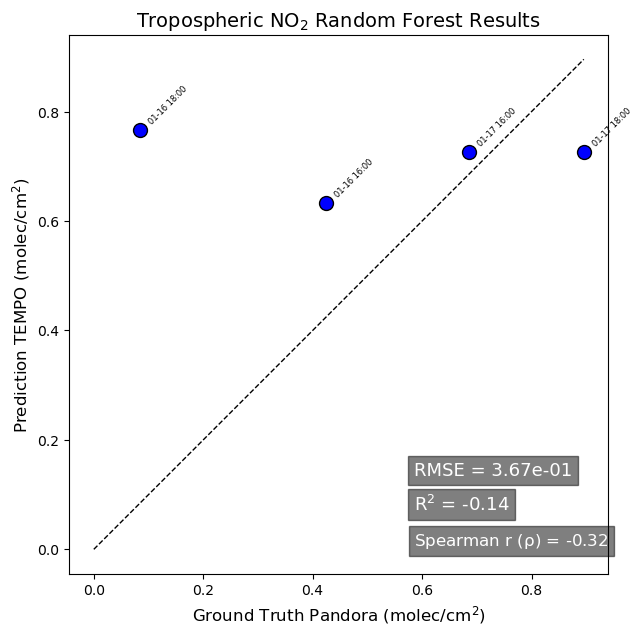

 2025-01-16, 2025-01-17


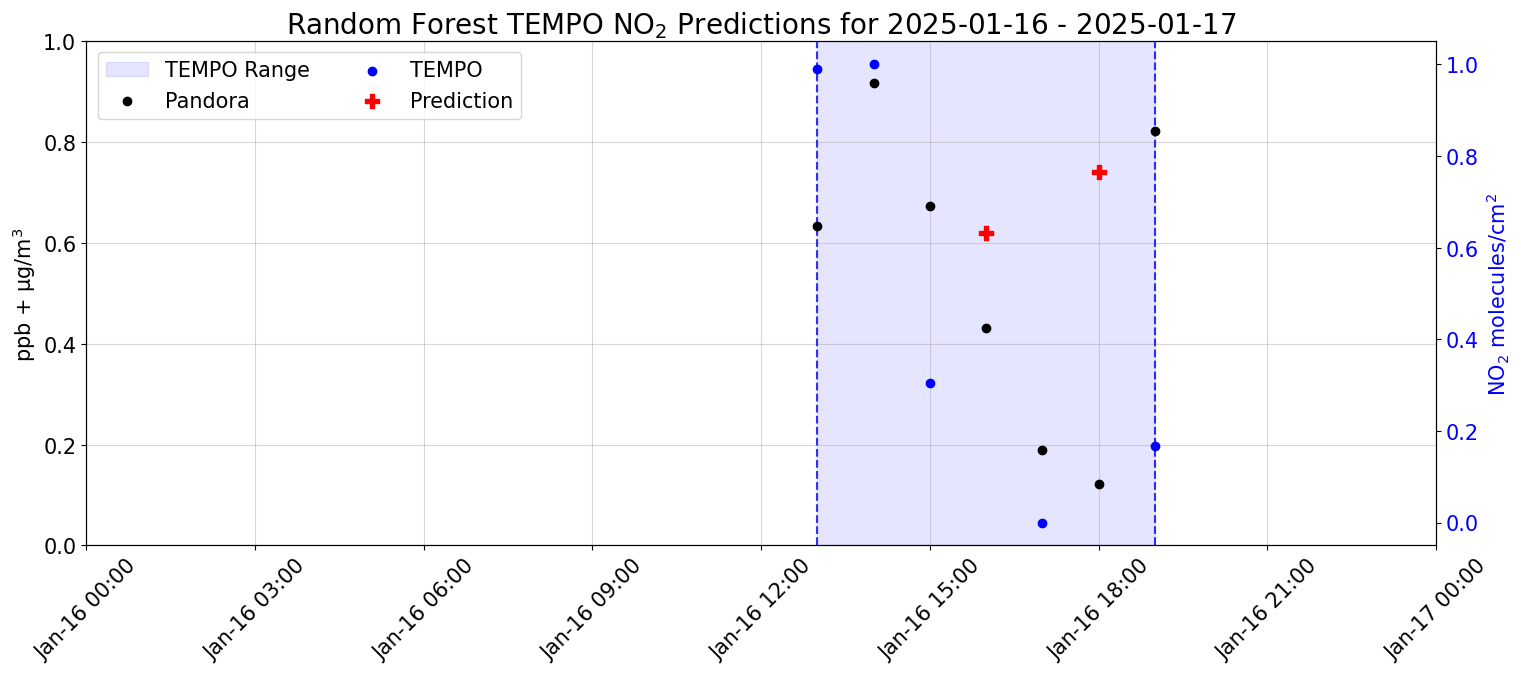

In [56]:
def one_dataframe(start_date, end_date, lat_, lon_, POI_name_, year):
    display(HTML("""<b>Select files (input number selection, comma separated) to process:</b><br>1. TEMPO<br>2. PANDORA<br>3. POWER<br>4. AirNow"""))
    file_choice = input().strip()
    files = [f.strip() for f in file_choice.split(',')]

    ### TEMPO AND PANDORA REQUIRED
    if '1' not in files or '2' not in files:
        raise ValueError("Both TEMPO (1) and PANDORA (2) must be selected.")

    tempo = pandora = power = airnow = None

    for f in files:
        if f == '1':
            tempo = tempo_processing(
                f'NO2_trop_col_noneg_{start_date}_{end_date}_{POI_name_}_'+str('%08.4fN_%08.4fW' %(lat_, -lon_))+'.txt',
                year=year,
                filename=f'TEMPO_{start_date}_{end_date}_{POI_name_}',
                save=False
            )
        elif f == '2':
            pandora = pandora_processing(
                f'NO2_trop_col_Pandora_{start_date}_{end_date}_{POI_name_}_'+str('%08.4fN_%08.4fW' %(lat_, -lon_))+'.txt',
                year=year,
                day_start=1,
                day_end=31,
                save=False,
                filename=f'PANDORA_{start_date}_{end_date}_{POI_name_}'
            )
        elif f == '3':
            power = power_processing(f'POWER_METEO_{start_date}_{end_date}_{POI_name_}.csv',
                                     year=year,
                                     save=False,
                                     filename=f'POWER_{start_date}_{end_date}_{POI_name_}'
                                    )
        elif f == '4':
            no2_path = f'AIRNOW_no2_{start_date}_{end_date}_{POI_name_}.csv'
            pm25_path = f'AIRNOW_pm25_{start_date}_{end_date}_{POI_name_}.csv'
            
            if os.path.isfile(no2_path) and os.path.isfile(pm25_path):
                airnow = airnow_processing(
                    no2_path,
                    pm25_path,
                    year=2024,
                    interpolate_missing=True,
                    save=False,
                    filename=f'AIRNOW_{start_date}_{end_date}_{POI_name_}'
                )
            else:
                print("Skipping AirNow processing: One or both AirNow files are missing.")

    # Ensure TEMPO and PANDORA data exist
    if tempo is None or pandora is None:
        raise ValueError("Error: Missing required datasets (TEMPO or PANDORA).")

    df = pd.merge(tempo, pandora, on=['year', 'month', 'day', 'hour'], how='left')

    if power is not None:
        df = pd.merge(df, power, on=['year', 'month', 'day', 'hour'], how='left')

    df.drop(columns=[col for col in ['Timestamp_y', 'Timestamp_x', 'Timestamp'] if col in df.columns], inplace=True)

    if airnow is not None:
        df = pd.merge(df, airnow, on=['year', 'month', 'day', 'hour'], how='left')
    for col, missing_count in df.isna().sum().items():
        if col not in list(tempo):
            if missing_count > 0: 
                print(f"Interpolating {missing_count} missing values in: {col}")
                df[col] = df[col].interpolate('linear')
        
    df['Timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    display(HTML("<b>Select model (input number selection):</b><br>1. Random Forest<br>2. Linear Regression"))
    model_choice = input().strip()
    if model_choice == '1':
        model_name = 'Random Forest'
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        for feat in list(df):
            print(feat)
        display(HTML("<b>Input comma-separated list of features to use:</b>"))
        feature_choice = input().strip()
        feats = [f.strip() for f in feature_choice.split(',') if f.strip() in df.columns]        
        
        print(f'Running Random Forest with features {feats}')
        preds, truth, date = train_model(df, model, feats)
        plot_result(preds, truth, date, upper_bound=max(truth), \
                    save = False, \
                    xlabel = 'Pandora',\
                    title=r'Tropospheric $NO_{2}$ Random Forest Results',\
                    fig_name = 'rf_2024')
        display(HTML("<b>For visualization, input date range in formate YYYY-MM-DD, YYYY-MM-DD (ex. 2025-01-05, 2025-01-10) :</b>"))
        dates = input().strip()
        dates = [f.strip() for f in dates.split(',')]
        visual_plot(df,model_name, airnow,preds,
                    date, dates[0], dates[1])
    else:
        model = LinearRegression()
        model_name = 'Linear Regression'
        for feat in list(df):
            print(feat)
        display(HTML("<b>Input comma-separated list of features to use:</b>"))
        feature_choice = input().strip()
        feats = [f.strip() for f in feature_choice.split(',') if f.strip() in df.columns]        
        
        print(f'Running Linear Regression with features {feats}')
        preds, truth, date = train_model(df, model, feats)
        plot_result(preds, 
                    truth, 
                    date, 
                    upper_bound=max(truth), \
                    save = False, \
                    xlabel = 'Pandora',\
                    title=r'Tropospheric $NO_{2}$ Linear Regression Results',\
                    fig_name = 'rf_2024')

        
        display(HTML("<b>For visualization, input date range in formate YYYY-MM-DD, YYYY-MM-DD (ex. 2025-01-05, 2025-01-10) :</b>"))
        dates = input().strip()
        dates = [f.strip() for f in dates.split(',')]
        visual_plot(df, model_name, airnow,
                    preds,
                    date, dates[0], dates[1])
                
one_dataframe(start_date, end_date,lat_, lon_, POI_name_, 2025)

In [86]:
scaler = MinMaxScaler()
df = tmpa

# df = df.drop(columns = ['minute'])
df= df.iloc[:,[0] +list(range(20, df.shape[1]))] #ignore coordinates and uncertanties
df = df.iloc[1:, :]
# df['NO2_both'] = np.where(
#     (df['NO2'].notna()), (df['NO2']*0.1 + df['NO2_pan']*0.9),  # Average when NO2 is valid
#     df['NO2_pan'])  # Use NO2_pan otherwise)

train_features = ['day', 'hour', 'T2M', 'RH2M', 'PS', 'WS10M','WD10M', 'pm25', 'no2'] #training features
# df[train_features] = scaler.fit_transform(df[train_features])
# df['NO2_pan'] = scaler.fit_transform(df[['NO2_pan']])
# df['NO2'] = scaler.fit_transform(df[['NO2']])


train_x = df[pd.isnull(df['NO2']) == False].reset_index(drop=True) #partition df where TEMPO vars are avail

rf = RandomForestRegressor()
rf.fit(train_x[train_features], train_x['NO2_both']) #train on featuresprovided (X), against pandora values (y)

pred_y = df[pd.isnull(df['NO2'])==True].reset_index(drop=True) #partition df for variables avail when TEMPO is not avail
pred_y['NO2_pred'] = rf.predict(pred_y[train_features])
pred_y = pred_y.dropna(axis=1, how='all')

KeyError: 'NO2'

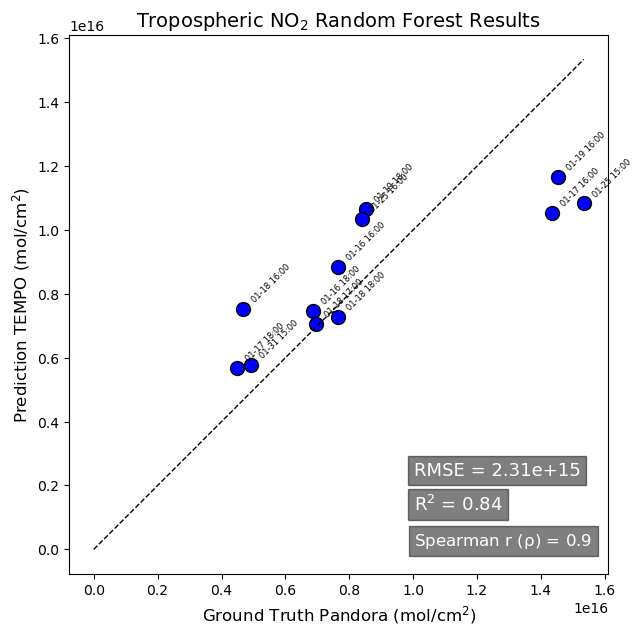

In [121]:
preds = pred_y['NO2_pred'].reset_index(drop=True)
truth = pred_y['NO2_pan'].reset_index(drop=True)    
date = pd.to_datetime(pred_y['datetime'])
plot_result(preds, truth, date, upper_bound=max(truth), \
            save = False, \
            xlabel = 'Pandora',\
            title=r'Tropospheric $NO_{2}$ Random Forest Results',\
            fig_name = 'rf_pan_poly_5')

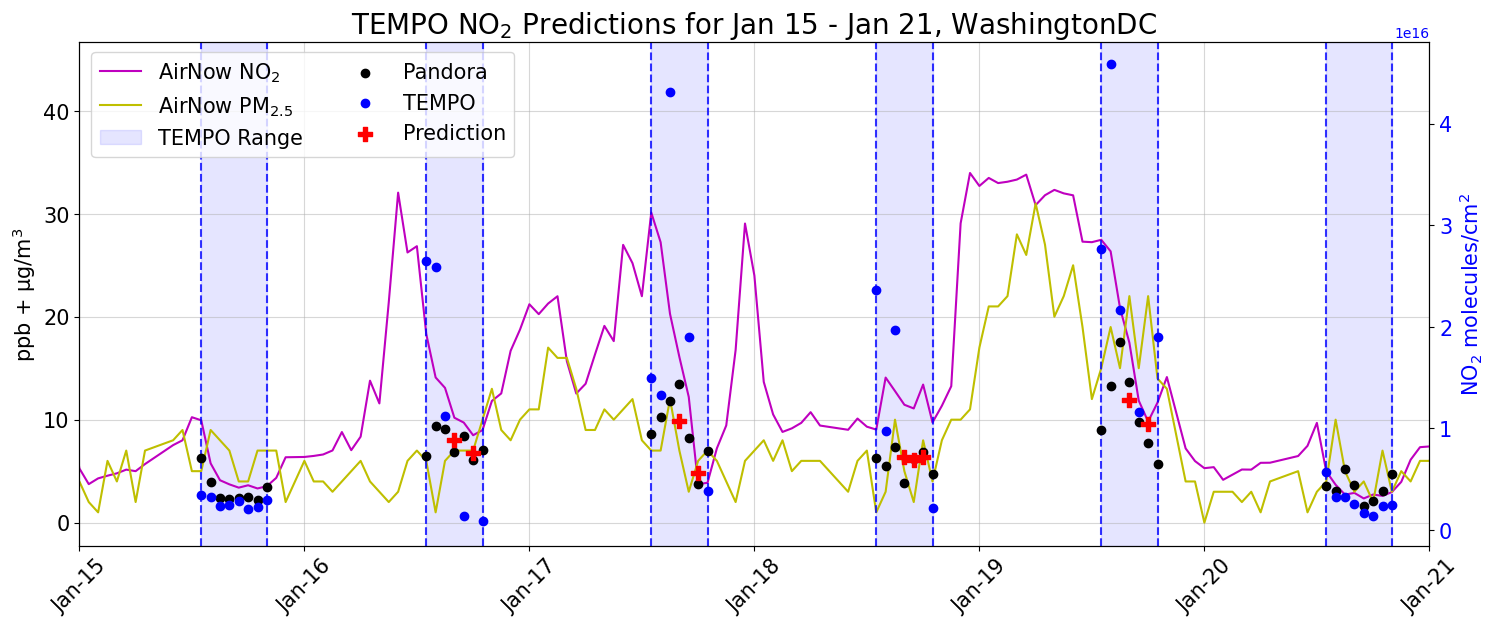

In [82]:
# Create axes with shared x
fig, ax = plt.subplots(figsize=(15, 8),gridspec_kw=dict(bottom=0.25, left=0.05, right=0.95))

ax.tick_params(axis='x', labelrotation=45)
ax.grid(True, linestyle='-', alpha=0.5)
tax = ax.twinx()

df['datetime'] = pd.to_datetime(df['datetime'])  # Ensure timestamps are in datetime format
air_pow_int['Timestamp'] = pd.to_datetime(air_pow_int['Timestamp'])  # Ensure timestamps are in datetime format

ax.plot(air_pow_int['Timestamp'], air_pow_int['no2'], color = 'm', label = r'AirNow NO$_{2}$')
ax.plot(air_pow_int['Timestamp'], air_pow_int['pm25'], c = 'y', label = r'AirNow PM$_{2.5}$')
ax.tick_params(axis='y',  labelsize = 15)

ax.set_ylabel(r'ppb + $\mu$g/m$^{3}$',fontsize = 15)


# # # ####Add TEMPO NO2
tax.scatter(df['datetime'], df['NO2_pan'], color = 'k', label = 'Pandora')
tax.scatter(df['datetime'], df['NO2'], color = 'b', label = 'TEMPO')
tax.set_ylabel(r'$NO_{2}$ molecules/cm$^2$',c='b', fontsize = 15)
tax.tick_params(axis='y',  labelcolor='b',labelsize = 15)


tempo_start = df['datetime'].min()
tempo_end =df['datetime'].max()

data = df.copy()  # Ensure we're working on a separate copy
data.loc[:, 'day'] = data['datetime'].dt.date  # Extract only the date part
data['datetime'] = pd.to_datetime(data['datetime'])  # Ensure datetime format
data['day'] = pd.to_datetime(data['datetime'].dt.date)  # Convert back to Pandas datetime


unique_days = data['day'].unique()
first_shade = True
for day in unique_days:
    day_data = data[data['day'] == day]  # Filter data for this specific day
    tempo_start = day_data['datetime'].min()
    tempo_end = day_data['datetime'].max()

    # Add vertical lines for the day's start and end
    ax.axvline(tempo_start, color='b', linestyle='--', alpha=0.8)
    ax.axvline(tempo_end, color='b', linestyle='--', alpha=0.8)

    if first_shade:
        ax.axvspan(tempo_start, tempo_end, color='b', alpha=0.1, label='TEMPO Range')
        first_shade = False  # Disable further labels
    else:
        ax.axvspan(tempo_start, tempo_end, color='b', alpha=0.1)

# # RF PREDS
tax.scatter(date, preds, marker='P', c='r', s = 100, label='Prediction')

# Define the desired date range
start_date = pd.Timestamp('2025-01-15')
end_date = pd.Timestamp('2025-01-21')

# Set x-axis limits to only show this range
ax.set_xlim(start_date, end_date)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically choose good tick locations
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))  # Format tick labels
ax.tick_params(axis='x', labelrotation=45, labelsize = 15)

fig.legend(loc="upper right", bbox_to_anchor=(.33, 1), bbox_transform=ax.transAxes, ncol=2, fontsize=15)
ax.set_title(rf'TEMPO $NO_{2}$ Predictions for Jan 15 - Jan 21, {POI_name_}', fontsize = 20)
plt.show()
# # # Or save out figure
fig.savefig('rfpred_updated_0325.png', dpi = 300)

In [313]:
total = pd.merge(df, pred_y, how='outer')
total['NO2'] = total['NO2'].fillna(total['NO2_pred'])
total = total.drop(columns=['NO2_pred'])


In [322]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [318]:
train_features = ['day', 'hour', 'T2M', 'RH2M', 'PS', 'WS10M','WD10M', 'pm25', 'no2'] #training features
train_x = total[pd.isnull(total['NO2']) == False].reset_index(drop=True) #partition df where TEMPO vars are avail

rf = LinearRegression()
rf.fit(train_x[train_features], train_x['NO2_pan']) #train on featuresprovided (X), against pandora values (y)

pred_y = df[pd.isnull(df['NO2'])==True].reset_index(drop=True) #partition df for variables avail when TEMPO is not avail

In [319]:
pred_y['NO2_pred'] = rf.predict(pred_y[train_features])
pred_y = pred_y.dropna(axis=1, how='all')

In [320]:
pred_y

,day,hour,datetime,T2M,RH2M,PS,WS10M,WD10M,WS50M,WD50M,RHOA,QV10M,pm25,no2,NO2_pan,NO2_pred
0,16,16,2025-01-16 16:00:00,-0.99,81.91,100.15,2.81,212.5,4.93,213.1,1.28,2.78,7.000000,10.190000,7.660280e+15,6.944992e+15
1,16,18,2025-01-16 18:00:00,-1.69,88.69,100.21,2.08,217.0,3.48,216.9,1.28,2.88,7.000000,8.490000,6.870283e+15,6.624994e+15
2,17,16,2025-01-17 16:00:00,0.76,79.13,101.10,2.77,184.1,4.84,184.4,1.27,2.88,7.000000,16.090000,1.435300e+16,7.979328e+15
3,17,18,2025-01-17 18:00:00,-1.11,81.79,101.12,4.04,166.2,8.15,166.6,1.27,2.77,6.000000,3.740000,4.476925e+15,6.211896e+15
4,18,16,2025-01-18 16:00:00,2.41,100.00,99.92,2.69,191.6,4.82,192.7,1.25,4.73,5.000000,11.450000,4.668750e+15,6.351513e+15
5,18,17,2025-01-18 17:00:00,0.75,100.00,99.97,3.33,197.8,5.92,198.1,1.25,4.70,2.000000,11.090000,6.972500e+15,5.966813e+15
6,18,18,2025-01-18 18:00:00,0.58,100.00,100.02,3.48,205.3,6.59,205.2,1.25,4.73,8.000000,13.410000,7.659200e+15,6.825663e+15
7,19,16,2025-01-19 16:00:00,-0.39,88.23,99.82,8.57,338.0,10.72,338.8,1.28,3.21,22.000000,17.480000,1.453792e+16,8.281868e+15
8,19,18,2025-01-19 18:00:00,-2.09,87.22,100.08,7.89,328.8,10.23,330.2,1.29,2.74,22.000000,9.820000,8.514967e+15,7.551550e+15
9,25,15,2025-01-25 15:00:00,2.71,51.49,101.79,4.55,216.1,6.71,216.6,1.28,2.12,11.512195,32.541951,1.534567e+16,1.102999e+16


In [324]:
# mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(pred_y['NO2_pan'], pred_y['NO2_pred'])
mse = mean_squared_error(pred_y['NO2_pan'], pred_y['NO2_pred'])

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 9832885346470591132704002015232.0000
R² Score: 0.2945


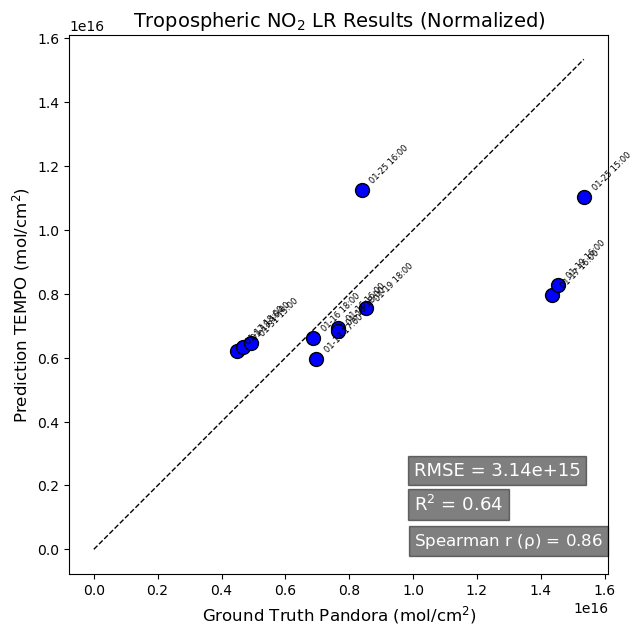

In [326]:
preds = pred_y['NO2_pred'].reset_index(drop=True)
truth = pred_y['NO2_pan'].reset_index(drop=True)    
date = pd.to_datetime(pred_y['datetime'])
plot_result(preds, truth, date, upper_bound=max(truth), \
            save = False, \
            xlabel = 'Pandora',\
            title=r'Tropospheric $NO_{2}$ LR Results (Normalized)',\
            fig_name = 'rf_pan_poly_5')

In [6]:
start_date, end_date, POI_name_ = 20250101, 20250131, 'WashingtonDC'

In [40]:
# tempo = tempo_processing('NO2_trop_col_noneg_20250101_20250131_WashingtonDC_038.9218N_077.0124W.txt', filename = f'TEMPO_{start_date}_{end_date}_{POI_name_}', save=False)
# pandora = pandora_processing('NO2_trop_col_Pandora_20250101_20250131_WashingtonDC_038.9218N_077.0124W.txt', day_start = 1, day_end = 31, save = False, filename = f'PANDORA_{start_date}_{end_date}_{POI_name_}')
# airnow_power = airnow_power_processing('AIRNOW_no2_20250101_20250131_WashingtonDC.csv', 'AIRNOW_pm25_20250101_20250131_WashingtonDC.csv','POWER_METEO_20250101_20250131_WashingtonDC.csv', f'AIRNOW_POWER_{start_date}_{end_date}_{POI_name_}', save=False)

# air_pow_int = airnow_power.interpolate('linear')
# tmpar =pd.merge(tempo, air_pow_int,on =['year', 'month', 'day', 'hour'], how='left')
# tmpar = tmpar.drop(columns = ['Timestamp_x', 'Timestamp_y'])
# tmpar = tmpar.rename(columns = {'datetime_y': 'datetime'})
# tmpa = pd.merge(tmpar, pandora, on =['year', 'month', 'day', 'hour'], how ='left')
# tmpa = tmpa.drop(columns = ['Timestamp'])
# tmpa['Timestamp'] = pd.to_datetime(tmpa[['year', 'month', 'day', 'hour']])
# tmpa['NO2_pan'] = tmpa['NO2_pan'].interpolate('linear')
tmpa.set_index("datetime", inplace=True)

In [41]:
tmpa = tmpa.iloc[2:]


In [42]:
df=tmpa

df['rolling_mean_1d'] = df['NO2'].rolling(window=1, min_periods=1).mean()
# df['rolling_std_1d'] = df['NO2'].rolling(window=1, min_periods=1).std()
# # Rolling mean for the last 6 hours
df['rolling_mean_6h'] = df['NO2'].rolling(window=6, min_periods=1).mean()

# Lag features: Previous day's measurement (shift by 1 day)
df['lag_1d'] = df['NO2'].shift(1)

# # Lag of rolling mean from the last day

df['lag_rolling_mean_1d'] = df['rolling_mean_1d'].shift(1)
feats = ['lag_1d', 'rolling_mean_6h', 'rolling_mean_1d','day', 'hour', 'T2M', 'RH2M', 'PS', 'WS10M','WD10M', 'pm25', 'no2']


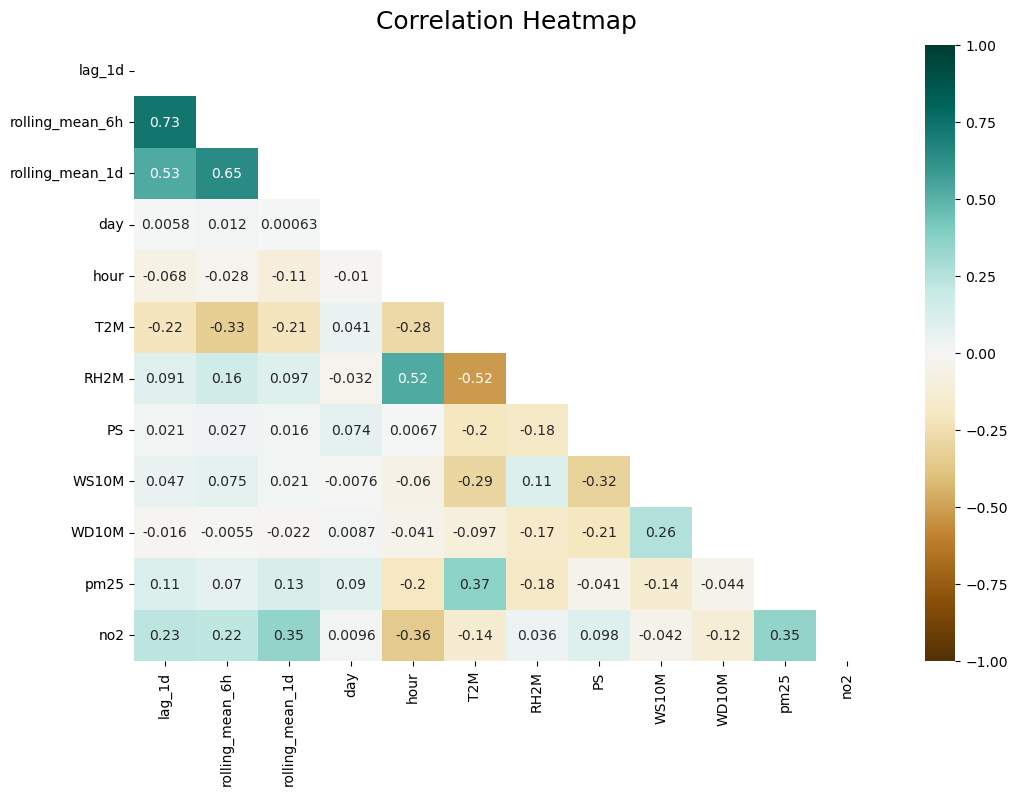

In [43]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,8))
mask = np.triu(np.ones_like(df[feats].corr(numeric_only=True), dtype=bool))
heatmap = sns.heatmap(df[feats].corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
figure = heatmap.get_figure()    
# figure.savefig('corr_coef.png', dpi=400)

In [44]:
def plot_result(predictions, gt, dates_df, upper_bound=175, save=True, xlabel = '', title = '', fig_name=''):
    Rsquared = stats.spearmanr(predictions, gt)[0]
    pvalue = stats.spearmanr(predictions, gt)[1]
    Rsquared_pearson = stats.pearsonr(predictions, gt)[0]
    pvalue_pearson = stats.pearsonr(predictions, gt)[1]
    
    #plot
    plt.rcParams.update({'mathtext.default': 'regular'})
    rmse = np.sqrt(metrics.mean_squared_error(gt, predictions))

    fig, ax = plt.subplots(figsize=(7, 7))
    lower_bound=0
    ax.scatter(gt, predictions, color='blue', edgecolors=(0, 0, 0), s=100)
    # date_labels = dates_df.dt.strftime("%m-%d %H:%M").tolist()
    # for i, date_str in enumerate(date_labels):
    #     ax.annotate(date_str, (gt[i], predictions[i]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=6, color='black', rotation=45)

    ax.plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'k--', lw=1)
    ax.set_xlabel(rf'Ground Truth {xlabel} (molec$\cdot$cm$^{-2}$)', size=12)
    ax.set_ylabel(r'Prediction TEMPO (molec$\cdot$cm$^{-2}$)', size=12)
    ax.set_title(title, fontsize=14)
    ax.tick_params(labelsize=10)
    
    bbox_props = dict(facecolor="black", alpha=0.5)

    fig.text(0.62, 0.15, r'Spearman r ($\rho$) = ' + str(round(Rsquared, 2)), fontsize=12,bbox=bbox_props, color='white')
    fig.text(0.62, 0.20, 'R$^2$ = ' + str(round(Rsquared_pearson, 2)), fontsize=13,bbox=bbox_props, color='white')
    fig.text(0.62, 0.25, f'RMSE = {rmse:.2e}', fontsize=13,bbox=bbox_props, color='white')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    if save:
        fig.savefig(fig_name + '.png', transparent=False, dpi=200, facecolor='white', bbox_inches='tight')
    return

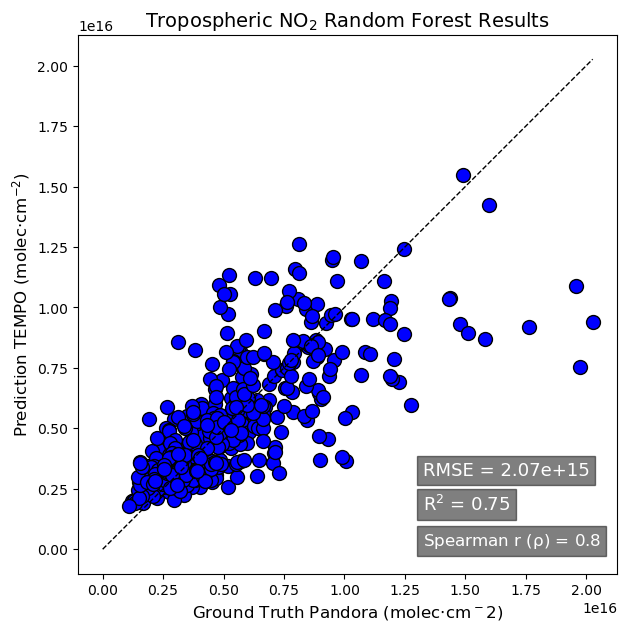

In [45]:
scaler = MinMaxScaler()

# df[feats] = scaler.fit_transform(df[feats])
# df['NO2_pan'] = scaler.fit_transform(df[['NO2_pan']])
# df['NO2'] = scaler.fit_transform(df[['NO2']])

train_x = df[pd.isnull(df['NO2']) == False].reset_index(drop=True) #partition df where TEMPO vars are avail
train_x.dropna(inplace=True)

pred_y = df[pd.isnull(df['NO2'])==True].reset_index(drop=True) #partition df for variables avail when TEMPO is not avail


# Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_x[feats], train_x['NO2_pan'])

# Make predictions
pred_y['preds'] = model.predict(pred_y[feats])

preds = pred_y['preds'].reset_index(drop=True)
truth = pred_y['NO2_pan'].reset_index(drop=True)    
date = pd.to_datetime(pred_y['Timestamp'])
plot_result(preds, truth, date, upper_bound=max(truth), \
            save = False, \
            xlabel = 'Pandora',\
            title=r'Tropospheric $NO_{2}$ Random Forest Results',\
            fig_name = 'rf_2024')

In [48]:
df

,year,month,day,hour,NO2,NO2_UNC,LAT_NE,LON_NE,NO2_NE,UNC_NE,LAT_SE,LON_SE,NO2_SE,UNC_SE,LAT_SW,LON_SW,NO2_SW,UNC_SW,LAT_NW,LON_NW,NO2_NW,UNC_NW,T2M,RH2M,PS,WS10M,WD10M,WS50M,WD50M,RHOA,QV10M,pm25,no2,NO2_pan,Timestamp,rolling_mean_1d,rolling_mean_6h,lag_1d,lag_rolling_mean_1d
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-01 16:00:00,2024,1,1,16,1.860000e+16,1.864000e+16,38.9277,-76.9743,2.218000e+16,1.927000e+16,38.9077,-76.9789,9930000000000000,18860000000000000,38.9062,-77.0380,-7825000000000000,19380000000000000,38.9261,-77.0335,23670000000000000,17800000000000000,3.97,90.13,100.97,3.37,303.1,5.18,303.4,1.27,4.44,4.0,3.59,3.901450e+15,2024-01-01 16:00:00,1.860000e+16,1.860000e+16,NaN,NaN
2024-01-01 17:00:00,2024,1,1,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.29,92.72,101.01,3.68,298.7,5.79,299.3,1.27,4.38,4.0,3.29,4.091100e+15,2024-01-01 17:00:00,NaN,1.860000e+16,1.860000e+16,1.860000e+16
2024-01-01 18:00:00,2024,1,1,18,3.140000e+16,3.108000e+16,38.9370,-77.0085,3.945000e+16,2.813000e+16,38.9173,-77.0129,28790000000000000,31910000000000000,38.9151,-77.0718,40700000000000000,41280000000000000,38.9349,-77.0673,58820000000000000,32190000000000000,2.88,93.32,101.03,4.28,301.5,6.31,302.0,1.27,4.28,4.0,3.10,4.280750e+15,2024-01-01 18:00:00,3.140000e+16,2.500000e+16,NaN,NaN
2024-01-01 19:00:00,2024,1,1,19,5.115000e+16,3.634000e+16,38.9305,-76.9638,-2.912000e+16,3.499000e+16,38.9105,-76.9684,86760000000000000,38220000000000000,38.9079,-77.0276,30440000000000000,33050000000000000,38.9277,-77.0231,36260000000000000,37740000000000000,2.46,94.61,101.04,4.45,305.3,6.55,306.2,1.28,4.22,2.0,3.31,5.315276e+15,2024-01-01 19:00:00,5.115000e+16,3.371667e+16,3.140000e+16,3.140000e+16
2024-01-01 20:00:00,2024,1,1,20,2.380000e+16,3.862000e+16,38.9229,-76.9921,2.883000e+16,3.727000e+16,38.9031,-76.9966,20720000000000000,40740000000000000,38.9016,-77.0546,19080000000000000,39320000000000000,38.9215,-77.0501,15070000000000000,40860000000000000,2.43,94.38,101.05,4.86,319.3,7.19,320.9,1.28,4.20,4.0,3.91,6.349802e+15,2024-01-01 20:00:00,2.380000e+16,3.123750e+16,5.115000e+16,5.115000e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 16:00:00,2024,12,31,16,4.776000e+15,1.613000e+15,38.9327,-77.0099,7.074000e+15,1.857000e+15,38.9130,-77.0144,2908000000000000,1415000000000000,38.9109,-77.0736,5329000000000000,1033000000000000,38.9306,-77.0693,13650000000000000,2694000000000000,11.51,80.86,99.42,5.82,145.9,9.71,146.9,1.21,6.85,7.0,6.59,3.611275e+15,2024-12-31 16:00:00,4.776000e+15,1.074617e+16,1.808000e+16,1.808000e+16
2024-12-31 17:00:00,2024,12,31,17,4.671000e+15,1.375000e+15,38.9270,-77.0017,5.038000e+15,1.216000e+15,38.9072,-77.0062,3695000000000000,1396000000000000,38.9057,-77.0636,5604000000000000,1185000000000000,38.9255,-77.0592,4836000000000000,1903000000000000,9.84,91.92,99.39,4.76,141.1,8.64,142.4,1.21,7.04,3.0,3.83,2.658650e+15,2024-12-31 17:00:00,4.671000e+15,1.068183e+16,4.776000e+15,4.776000e+15
2024-12-31 18:00:00,2024,12,31,18,3.748000e+15,8.928000e+14,38.9351,-76.9613,4.253000e+15,1.222000e+15,38.9151,-76.9659,2370000000000000,848200000000000,38.9132,-77.0241,3801000000000000,753400000000000,38.9330,-77.0196,4253000000000000,1049000000000000,9.59,95.69,99.35,4.81,141.1,7.88,143.0,1.22,7.21,4.0,3.85,2.932400e+15,2024-12-31 18:00:00,3.748000e+15,1.060217e+16,4.671000e+15,4.671000e+15


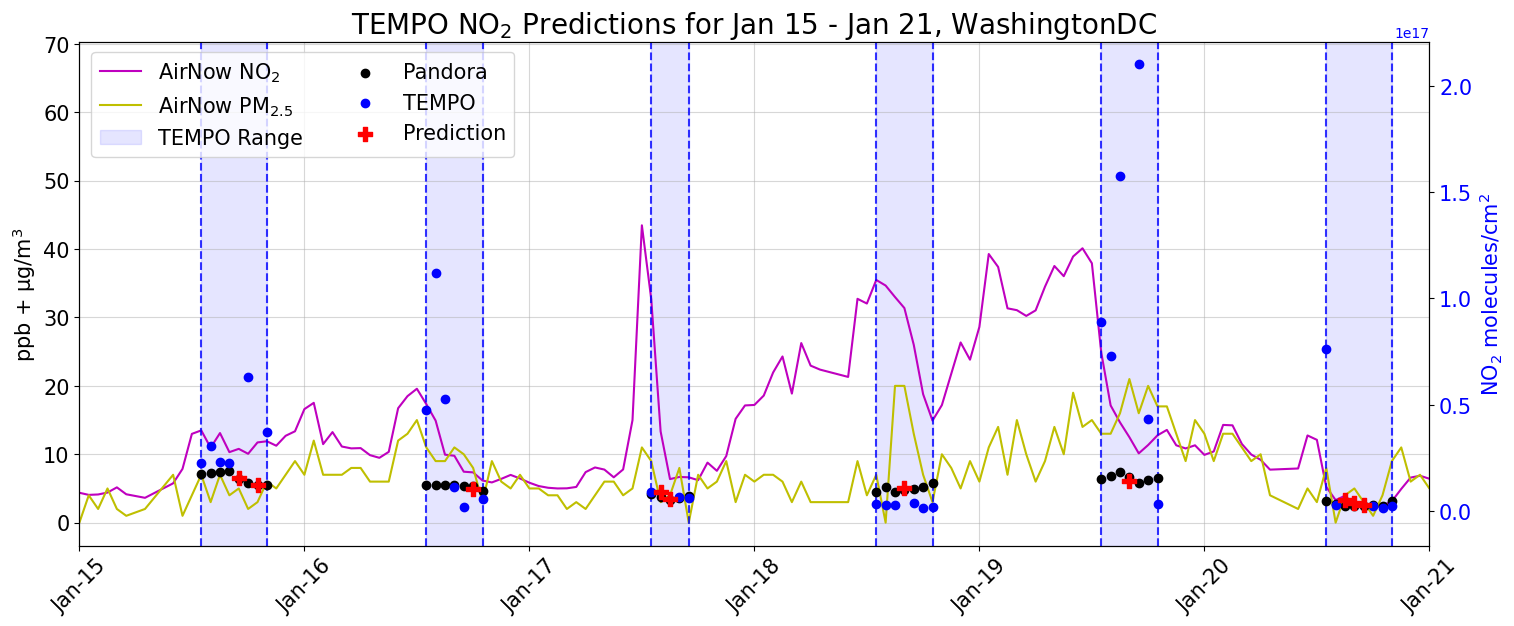

In [50]:
fig, ax = plt.subplots(figsize=(15, 8),gridspec_kw=dict(bottom=0.25, left=0.05, right=0.95))

ax.tick_params(axis='x', labelrotation=45)
ax.grid(True, linestyle='-', alpha=0.5)
tax = ax.twinx()
df = df.reset_index()

df['datetime'] = pd.to_datetime(df['datetime'])  # Ensure timestamps are in datetime format
air_pow_int['Timestamp'] = pd.to_datetime(air_pow_int['Timestamp'])  # Ensure timestamps are in datetime format

ax.plot(air_pow_int['Timestamp'], air_pow_int['no2'], color = 'm', label = r'AirNow NO$_{2}$')
ax.plot(air_pow_int['Timestamp'], air_pow_int['pm25'], c = 'y', label = r'AirNow PM$_{2.5}$')
ax.tick_params(axis='y',  labelsize = 15)

ax.set_ylabel(r'ppb + $\mu$g/m$^{3}$',fontsize = 15)


# # ####Add TEMPO NO2
tax.scatter(df['datetime'], df['NO2_pan'], color = 'k', label = 'Pandora')
tax.scatter(df['datetime'], df['NO2'], color = 'b', label = 'TEMPO')
tax.set_ylabel(r'$NO_{2}$ molecules/cm$^2$',c='b', fontsize = 15)
tax.tick_params(axis='y',  labelcolor='b',labelsize = 15)


tempo_start = df['datetime'].min()
tempo_end =df['datetime'].max()

data = df.copy()  # Ensure we're working on a separate copy
data.loc[:, 'day'] = data['datetime'].dt.date  # Extract only the date part
data['datetime'] = pd.to_datetime(data['datetime'])  # Ensure datetime format
data['day'] = pd.to_datetime(data['datetime'].dt.date)  # Convert back to Pandas datetime


unique_days = data['day'].unique()
first_shade = True
for day in unique_days:
    day_data = data[data['day'] == day]  # Filter data for this specific day
    tempo_start = day_data['datetime'].min()
    tempo_end = day_data['datetime'].max()

    # Add vertical lines for the day's start and end
    ax.axvline(tempo_start, color='b', linestyle='--', alpha=0.8)
    ax.axvline(tempo_end, color='b', linestyle='--', alpha=0.8)

    if first_shade:
        ax.axvspan(tempo_start, tempo_end, color='b', alpha=0.1, label='TEMPO Range')
        first_shade = False  # Disable further labels
    else:
        ax.axvspan(tempo_start, tempo_end, color='b', alpha=0.1)

# # RF PREDS
tax.scatter(date, preds, marker='P', c='r', s = 100, label='Prediction')

# Define the desired date range
start_date = pd.Timestamp('2024-01-15')
end_date = pd.Timestamp('2024-01-21')

# Set x-axis limits to only show this range
ax.set_xlim(start_date, end_date)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically choose good tick locations
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))  # Format tick labels
ax.tick_params(axis='x', labelrotation=45, labelsize = 15)

fig.legend(loc="upper right", bbox_to_anchor=(.33, 1), bbox_transform=ax.transAxes, ncol=2, fontsize=15)
ax.set_title(rf'TEMPO $NO_{2}$ Predictions for Jan 15 - Jan 21, {POI_name_}', fontsize = 20)
plt.show()
# # # # Or save out figure
# fig.savefig('rfpred_updated_0325.png', dpi = 300)

In [159]:
total = pd.merge(df, pred_y, how='outer')

In [161]:
total['NO2'] = total['NO2'].fillna(total['preds'])

In [162]:
total.isna().sum()

year                      0
month                     0
day                       0
hour                      0
datetime                  0
NO2                       0
NO2_UNC                 459
LAT_NE                  459
LON_NE                  459
NO2_NE                  459
UNC_NE                  459
LAT_SE                  459
LON_SE                  459
NO2_SE                  459
UNC_SE                  459
LAT_SW                  459
LON_SW                  459
NO2_SW                  459
UNC_SW                  459
LAT_NW                  459
LON_NW                  459
NO2_NW                  459
UNC_NW                  459
T2M                       0
RH2M                      0
PS                        0
WS10M                     0
WD10M                     0
WS50M                     0
WD50M                     0
RHOA                      0
QV10M                     0
pm25                      0
no2                       0
NO2_pan                   0
Timestamp           

In [164]:
total = total.drop(columns=['preds'])


In [165]:
total.to_csv('complete_predictions_2024.csv', index=False)